# Import dependencies

In [3263]:
import cv2
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import matplotlib
import scipy as scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os, fnmatch
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 10})
import util
import re  # For regex
import seaborn as sns
import scipy.stats as stats
from matplotlib.transforms import Affine2D

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import and Concatenate files

In [3264]:
summary_dir = r"C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1"
dlc_dir = r"D:\Barrier_testing_day1_videos"
#SIT_dir = r"C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1\SIT"

In [3265]:
# Column names for the summary data
summary_columns = [
    "date", "subject", "sex", "condition", "experiment_name",
    "HR_Arm", "arm_choice", "eat", "start_time", "choice_time", "eat_time"
]

In [3266]:
# Function to collect specific files based on a naming pattern
def get_files_by_pattern(directory, pattern):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if pattern in file:
                file_paths.append(os.path.join(root, file))
    return file_paths

In [3267]:
dlc_dir = r"D:\Barrier_testing_day1_videos"
for root, _, files in os.walk(dlc_dir):
    for file in files:
        print(file)


031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0.avi
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0.mp4v
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000.h5
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_filtered.csv
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_filtered.h5
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_meta.pickle
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_1.avi
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_1.mp4v
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_10.avi
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_10.mp4v
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_10DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000.h

In [3268]:
# Get all relevant files
summary_files = get_files_by_pattern(summary_dir, "TrialData.csv")
dlc_files = get_files_by_pattern(dlc_dir, "filtered.h5")
#SIT_files = get_files_by_pattern(SIT_dir, "VideoData.csv")

In [3269]:
# Process summary files
summary_combined = []
for summary_file in summary_files:
    summary_df = pd.read_csv(summary_file, header=None, names=summary_columns)

    # Filter rows with *Barrier_Testing* in the experiment_name column
    #summary_df = summary_df[summary_df['experiment_name'].str.contains("Barrier_Testing", na=False)]
    summary_df = summary_df[summary_df['experiment_name'].str.contains("barrier_testing", case=False, na=False)]
    
    # Add a 'trial' column based on the row index (1-based indexing for trial numbers)
    summary_df['trial'] = summary_df.index + 1
    summary_combined.append(summary_df)

In [3270]:
# Combine all summary data
summary_df = pd.concat(summary_combined, ignore_index=True)

In [3272]:
def clean_experiment_name(name):
    name = name.lower().strip()  # Normalize case and strip spaces
    name = re.sub(r'__+', '_', name)  # Replace multiple underscores with one
    name = re.sub(r'[^a-z0-9_]', '', name)  # Remove unexpected characters
    name = re.sub(r'barrier[_]?testing[_]?(10|15|20)cm[_]?day[_]?(\d)', r'Barrier_Testing_\1cm_Day_\2', name)
    return name

summary_df['experiment_name'] = summary_df['experiment_name'].apply(clean_experiment_name)


In [3273]:
summary_df['experiment_name'] = summary_df['experiment_name'].str.replace(
    r'Barrier_Testing_(\d{2})cm_Day_(\d)', 
    r'\1cm_Barrier_Day\2',
    regex=True
)


In [3274]:
alldays_summary_df = summary_df.copy()

In [3280]:
summary_df['experiment_name'] = summary_df['experiment_name'].str.replace(
    r'Barrier_Testing_(\d{2})cm_Day_1',
    r'\1cm_Barrier_Day1',
    regex=True
)


In [3281]:
summary_df = summary_df[summary_df['experiment_name'].str.contains(r'Day[_]?1$', regex=True)]

In [3282]:
# Filter rows where experiment name is '10cm'
filtered_df = analysis_df[analysis_df['experiment'] == '10cm']

# Count the number of rows for each value in the 'sex' column in the filtered DataFrame
sex_counts = filtered_df['sex'].value_counts()

# Print counts for 'M' and 'F'
print("Number of males (M):", sex_counts.get('M', 0))
print("Number of females (F):", sex_counts.get('F', 0))


Number of males (M): 15
Number of females (F): 15


In [3283]:
# Count the number of rows for each value in the 'sex' column
sex_counts = analysis_df['sex'].value_counts()

# Print counts for 'M' and 'F'
print("Number of males (M):", sex_counts.get('M', 0))
print("Number of females (F):", sex_counts.get('F', 0))

Number of males (M): 42
Number of females (F): 44


# Choice

In [3285]:
# Lowercase the values in the 'HR_Arm' column
summary_df['HR_Arm'] = summary_df['HR_Arm'].str.lower()

# Create the 'choice' column based on comparison
summary_df['choice'] = summary_df['arm_choice'] == summary_df['HR_Arm']


In [3286]:
# Lowercase the values in the 'HR_Arm' column
alldays_summary_df['HR_Arm'] = alldays_summary_df['HR_Arm'].str.lower()

# Create the 'choice' column based on comparison
alldays_summary_df['choice'] = alldays_summary_df['arm_choice'] == alldays_summary_df['HR_Arm']


In [3287]:
# Ensure 'choice' is boolean
summary_df['choice'] = summary_df['choice'].astype(bool)

# Group by experiment_name and subject
grouped = summary_df.groupby(['experiment_name', 'subject'])

analysis_df = grouped['choice'].agg(
    HR_percentage=lambda x: x.sum() / len(x)
).reset_index()

# Get condition and sex info (drop duplicates to avoid merge issues)
meta_info = summary_df.drop_duplicates(subset=['experiment_name', 'subject'])[
    ['date', 'experiment_name', 'subject', 'condition', 'sex']
]

# Merge meta info into the analysis_df
analysis_df = analysis_df.merge(meta_info, on=['experiment_name', 'subject'], how='left')

In [3288]:
def parse_and_format_date(x):
    x = str(x).strip()
    if len(x) == 5:
        dt = pd.to_datetime(x, format='%m%d%y', errors='coerce')
    elif len(x) == 7:
        dt = pd.to_datetime(x, format='%m%d%Y', errors='coerce')
    else:
        return pd.NaT

    if pd.notnull(dt):
        # Manually build the string: month without leading zero + day + year
        return f"{dt.month}{dt.strftime('%d%y')}"  # e.g. '31524'
    else:
        return pd.NaT

alldays_summary_df['date'] = alldays_summary_df['date'].apply(parse_and_format_date)

In [3289]:
# Ensure 'choice' is boolean
alldays_summary_df['choice'] = alldays_summary_df['choice'].astype(bool)

# Group by experiment_name and subject
grouped = alldays_summary_df.groupby(['experiment_name', 'subject'])

alldays_analysis_df = grouped['choice'].agg(
    HR_percentage=lambda x: x.sum() / len(x)
).reset_index()

# Get condition and sex info (drop duplicates to avoid merge issues)
meta_info = alldays_summary_df.drop_duplicates(subset=['experiment_name', 'subject'])[
    ['date', 'experiment_name', 'subject', 'condition', 'sex']
]

# Merge meta info into the analysis_df
alldays_analysis_df = alldays_analysis_df.merge(meta_info, on=['experiment_name', 'subject'], how='left')

In [3290]:
# Count number of True in 'choice' per 'experiment_name' and 'subject'
alldays_true_counts = alldays_summary_df.groupby(['experiment_name', 'subject'])['choice'].sum().reset_index()

# Count the total number of rows per 'experiment_name' and 'subject' (i.e., total trials)
alldays_total_counts = alldays_summary_df.groupby(['experiment_name', 'subject']).size().reset_index(name='total_trials')

# Merge the two counts together
alldays_hr_ratio_df = pd.merge(alldays_true_counts, alldays_total_counts, on=['experiment_name', 'subject'])

# Calculate the HR ratio (True count / Total trials)
alldays_hr_ratio_df['HR_ratio'] = alldays_hr_ratio_df['choice'] / alldays_hr_ratio_df['total_trials']

# Merge HR_ratio into analysis_df based on 'experiment_name' and 'subject'
alldays_analysis_df = alldays_analysis_df.merge(alldays_hr_ratio_df, on=['experiment_name', 'subject'], how='left')

In [3291]:
# Count number of True in 'choice' per 'experiment_name' and 'subject'
true_counts = summary_df.groupby(['experiment_name', 'subject'])['choice'].sum().reset_index()

# Count the total number of rows per 'experiment_name' and 'subject' (i.e., total trials)
total_counts = summary_df.groupby(['experiment_name', 'subject']).size().reset_index(name='total_trials')

# Merge the two counts together
hr_ratio_df = pd.merge(true_counts, total_counts, on=['experiment_name', 'subject'])

# Calculate the HR ratio (True count / Total trials)
hr_ratio_df['HR_ratio'] = hr_ratio_df['choice'] / hr_ratio_df['total_trials']

# Merge HR_ratio into analysis_df based on 'experiment_name' and 'subject'
analysis_df = analysis_df.merge(hr_ratio_df, on=['experiment_name', 'subject'], how='left')


Original p-values:
10cm: 0.0360
15cm: 0.0742
20cm: 0.2931

Bonferroni-corrected p-values:
10cm: 0.1079
15cm: 0.2225
20cm: 0.8792


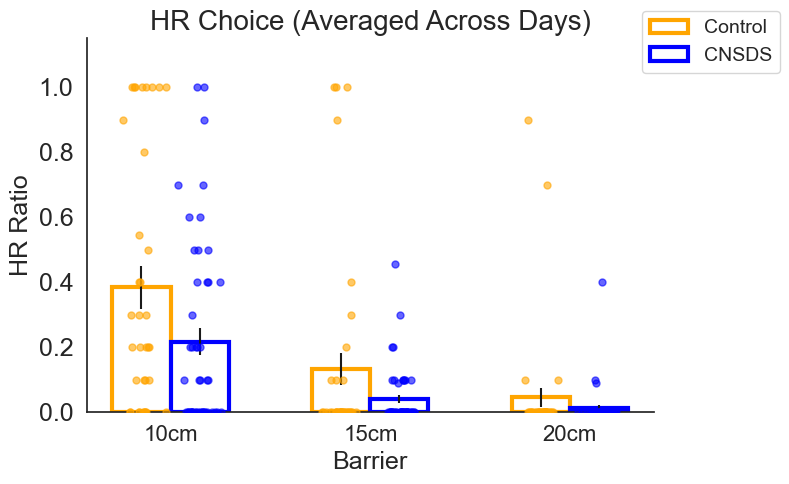

In [3295]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Your preprocessing code here...
df = alldays_analysis_df.copy()
df['barrier'] = df['experiment_name'].str.extract(r'(\d+cm)')
df['day'] = df['experiment_name'].str.extract(r'(Day\d)')
df['day_num'] = df['day'].str.extract(r'Day(\d)').astype(float)
df = df.dropna(subset=['day_num'])

if 'condition' not in df.columns:
    df['condition'] = df['experiment_name'].apply(lambda x: 'CNSDS' if 'CNSDS' in x else 'Control')

grouped = df.groupby(['barrier', 'condition'])['HR_ratio']
means = grouped.mean().reset_index()
sems = grouped.sem().reset_index()
summary = pd.merge(means, sems, on=['barrier', 'condition'], suffixes=('_mean', '_sem'))

sns.set(style='white')
colors = {'Control': 'orange', 'CNSDS': 'blue'}
barriers = ['10cm', '15cm', '20cm']

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35

x_labels = []
x_ticks = []
bar_index = 0
p_values = []
bar_centers = []

for barrier in barriers:
    subset = summary[summary['barrier'] == barrier]

    for j, condition in enumerate(['Control', 'CNSDS']):
        bar_x = bar_index + j * bar_width
        row = subset[subset['condition'] == condition]

        if not row.empty:
            mean = row['HR_ratio_mean'].values[0]
            sem = row['HR_ratio_sem'].values[0]

            # Add label only for the first barrier to avoid duplicate legend entries
            label = condition if barrier == barriers[0] else None

            # Plot bar (outlined only)
            ax.bar(
                bar_x, mean, yerr=sem, width=bar_width,
                facecolor='white',
                edgecolor=colors[condition],
                linewidth=3,
                label=label,
                zorder=2
            )

            # Individual datapoints with correct jitter
            raw_vals = df[(df['barrier'] == barrier) & (df['condition'] == condition)]['HR_ratio'].values
            x_jittered = bar_x + np.random.normal(0, 0.05, size=len(raw_vals))
            ax.scatter(
                x_jittered,
                raw_vals,
                color=colors[condition],
                s=25,
                alpha=0.6,
                zorder=3,
                label=None  # Do not duplicate legend here
            )

    # T-test
    group1 = df[(df['barrier'] == barrier) & (df['condition'] == 'Control')]['HR_ratio']
    group2 = df[(df['barrier'] == barrier) & (df['condition'] == 'CNSDS')]['HR_ratio']

    if len(group1) > 1 and len(group2) > 1:
        _, p_val = ttest_ind(group1, group2, equal_var=False)
    else:
        p_val = 1.0  # default if not enough data

    p_values.append(p_val)
    bar_centers.append(bar_index + bar_width / 2)
    x_labels.append(barrier)
    x_ticks.append(bar_index + bar_width / 2)
    bar_index += 1.2  # space between groups

# Bonferroni correction and asterisk annotation
rejects, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')
for i, (rej, p_corr) in enumerate(zip(rejects, pvals_corrected)):
    if rej:
        ax.text(
            bar_centers[i],
            max(ax.get_ylim()) * 0.95,
            '*',
            ha='center',
            va='bottom',
            fontsize=26,
            color='black'
        )

# Print stats
print("Original p-values:")
for barrier, pval in zip(barriers, p_values):
    print(f"{barrier}: {pval:.4f}")

print("\nBonferroni-corrected p-values:")
for barrier, pval_corr in zip(barriers, pvals_corrected):
    print(f"{barrier}: {pval_corr:.4f}")

# Style the plot
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, fontsize=16)
ax.set_ylabel('HR Ratio', fontsize=18)
ax.set_xlabel('Barrier', fontsize=18)
ax.set_title('HR Choice (Averaged Across Days)', fontsize=20)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylim(0, 1.15)
sns.despine()

# Extract legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Place legend outside to the right
fig.legend(
    handles, labels,
    loc='center left',
    bbox_to_anchor=(.8, .9),
    fontsize=14,
    title_fontsize=16
)

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig("Choice_across_days.pdf", format="pdf")
plt.show()



In [3298]:
# --- Step 1: Ensure 'date' is string ---

alldays_analysis_df['date'] = alldays_analysis_df['date'].astype(str)

# --- Step 2: Define date -> (cohort, barrier) map ---

date_barrier_map = {
    # Cohort 1
    '31524': ('Cohort 1', '10cm'), '31624': ('Cohort 1', '10cm'), '31724': ('Cohort 1', '10cm'),
    '31824': ('Cohort 1', '15cm'), '31924': ('Cohort 1', '15cm'), '32024': ('Cohort 1', '15cm'),
    '32124': ('Cohort 1', '20cm'), '32224': ('Cohort 1', '20cm'), '32224': ('Cohort 1', '20cm'),

    # Cohort 2
    '50524': ('Cohort 2', '10cm'), '50624': ('Cohort 2', '10cm'), '50724': ('Cohort 2', '10cm'),
    '50824': ('Cohort 2', '15cm'), '50924': ('Cohort 2', '15cm'), '51024': ('Cohort 2', '15cm'),
    '51124': ('Cohort 2', '20cm'), '51224': ('Cohort 2', '20cm'), '51324': ('Cohort 2', '20cm'),

    # Cohort 3
    '62724': ('Cohort 3', '10cm'), '62824': ('Cohort 3', '10cm'), '62924': ('Cohort 3', '10cm'),
    '63024': ('Cohort 3', '15cm'), '70124': ('Cohort 3', '15cm'), '70134': ('Cohort 3', '15cm'),
    '70224': ('Cohort 3', '20cm'), '70324': ('Cohort 3', '20cm'), '70424': ('Cohort 3', '20cm'),
}

# --- Step 3: Map cohort and barrier ---

alldays_analysis_df['cohort'] = alldays_analysis_df['date'].map(lambda d: date_barrier_map.get(d, (None, None))[0])
alldays_analysis_df['barrier'] = alldays_analysis_df['date'].map(lambda d: date_barrier_map.get(d, (None, None))[1])

# --- Step 4: Drop rows with unknown dates ---

alldays_analysis_df = alldays_analysis_df.dropna(subset=['cohort', 'barrier'])

# --- Optional: Preview result ---

print(alldays_analysis_df[['date', 'cohort', 'barrier']].head())


    date    cohort barrier
0  31524  Cohort 1    10cm
1  31524  Cohort 1    10cm
2  31524  Cohort 1    10cm
3  31524  Cohort 1    10cm
4  31524  Cohort 1    10cm


T-test Results (with Bonferroni correction):

Cohort 1 | 10cm | t = 0.052, p = 0.9585, p_corrected = 1.0000, n_control = 13, n_cnsds = 18, significant = False
Cohort 1 | 15cm | t = -0.456, p = 0.6524, p_corrected = 1.0000, n_control = 15, n_cnsds = 18, significant = False
Cohort 1 | 20cm | t = -1.000, p = 0.3388, p_corrected = 1.0000, n_control = 10, n_cnsds = 12, significant = False
Cohort 2 | 10cm | t = 0.914, p = 0.3710, p_corrected = 1.0000, n_control = 13, n_cnsds = 15, significant = False
Cohort 2 | 15cm | t = 0.041, p = 0.9680, p_corrected = 1.0000, n_control = 11, n_cnsds = 15, significant = False
Cohort 2 | 20cm | t = nan, p = nan, p_corrected = nan, n_control = 12, n_cnsds = 12, significant = False
Cohort 3 | 10cm | t = 3.749, p = 0.0026, p_corrected = 0.0232, n_control = 10, n_cnsds = 15, significant = True
Cohort 3 | 15cm | t = 1.487, p = 0.1784, p_corrected = 1.0000, n_control = 8, n_cnsds = 10, significant = False
Cohort 3 | 20cm | t = 1.181, p = 0.2578, p_corrected = 1.0

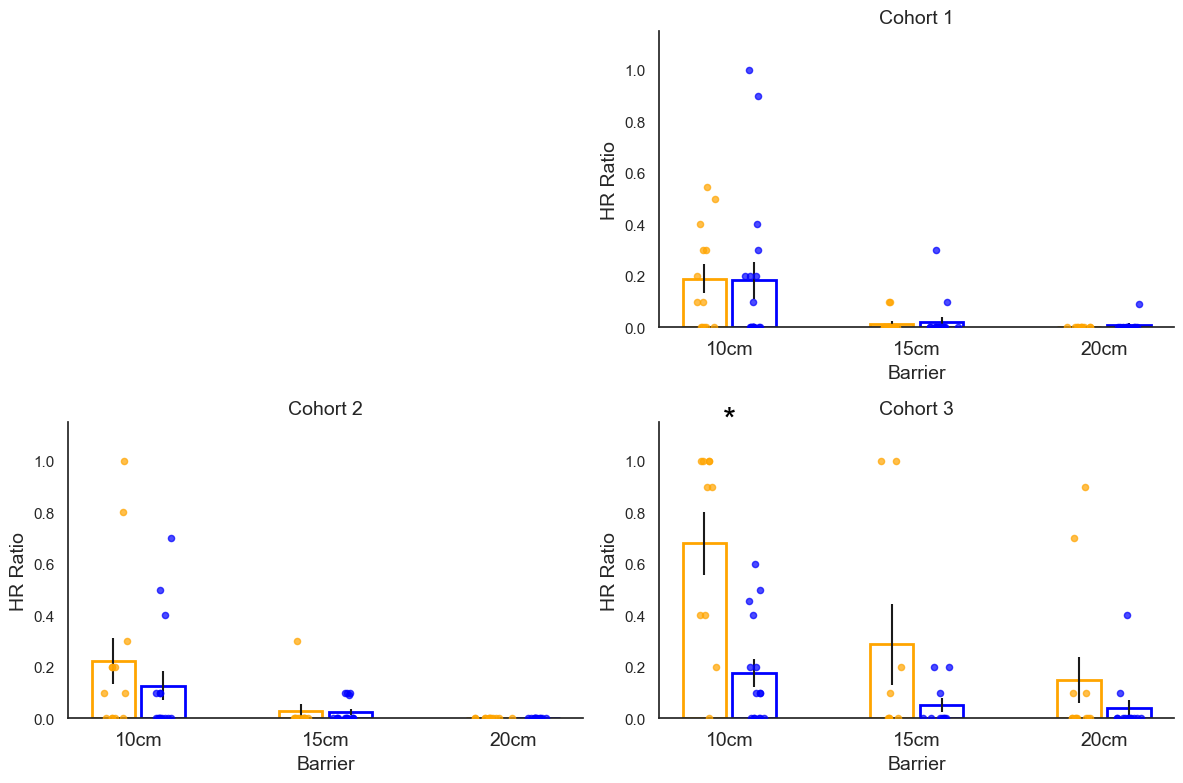

In [3300]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Ensure 'condition' is ordered
alldays_analysis_df['condition'] = pd.Categorical(alldays_analysis_df['condition'], ['Control', 'CNSDS'], ordered=True)

# Set color palette and barrier order
palette = {'Control': 'orange', 'CNSDS': 'blue'}
barriers = ['10cm', '15cm', '20cm']


# Setup 2x2 layout (3 plots, 1 empty slot)
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2)

# Define subplot locations
axes_layout = {
    'Cohort 1': fig.add_subplot(gs[0, 1]),
    'Cohort 2': fig.add_subplot(gs[1, 0]),
    'Cohort 3': fig.add_subplot(gs[1, 1])
}

# Store t-test results
results = []

# Plot for each cohort
for cohort in ['Cohort 1', 'Cohort 2', 'Cohort 3']:
    ax = axes_layout[cohort]
    df = alldays_analysis_df[alldays_analysis_df['cohort'] == cohort]

    x_ticks = []
    x_labels = []
    tick_pos = 0

    for barrier in barriers:
        for j, condition in enumerate(['Control', 'CNSDS']):
            group = df[(df['barrier'] == barrier) & (df['condition'] == condition)]
            mean = group['HR_ratio'].mean()
            sem = group['HR_ratio'].sem()
            x = tick_pos + (j * 0.4 - 0.2)

            # Bar: outline only, white fill
            ax.bar(
                x, mean, yerr=sem,
                width=0.35,
                facecolor='white',
                edgecolor=palette[condition],
                linewidth=2,
                zorder=2
            )

            # Jittered scatter points
            jitter = np.random.normal(0, 0.05, size=len(group))
            ax.scatter(
                x + jitter,
                group['HR_ratio'],
                color=palette[condition],
                s=20,
                alpha=0.7,
                zorder=3
            )

        # Add tick label at center between conditions
        x_ticks.append(tick_pos)
        x_labels.append(barrier)

        # T-test
        control_vals = df[(df['barrier'] == barrier) & (df['condition'] == 'Control')]['HR_ratio']
        cnsds_vals = df[(df['barrier'] == barrier) & (df['condition'] == 'CNSDS')]['HR_ratio']

        if len(control_vals) > 1 and len(cnsds_vals) > 1:
            t_val, p_val = ttest_ind(control_vals, cnsds_vals, equal_var=False)
        else:
            t_val, p_val = np.nan, 1.0

        results.append({
            'cohort': cohort,
            'barrier': barrier,
            't_val': t_val,
            'p_val': p_val,
            'n_control': len(control_vals),
            'n_cnsds': len(cnsds_vals),
            'x_center': tick_pos  # for annotation
        })

        tick_pos += 1.5

    # Style each plot
    ax.set_title(cohort, fontsize=14)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=14)
    ax.set_xlabel('Barrier', fontsize=14)
    ax.set_ylabel("HR Ratio", fontsize=14)
    ax.set_ylim(0, 1.15)
    sns.despine(ax=ax)

# Add empty subplot to top-left
fig.add_subplot(gs[0, 0]).axis('off')

# --- Bonferroni Correction ---
p_vals = [r['p_val'] for r in results]
rejects, pvals_corrected, _, _ = multipletests(p_vals, method='bonferroni')

# Annotate significance
for i, r in enumerate(results):
    r['p_val_corrected'] = pvals_corrected[i]
    r['significant'] = rejects[i]

    if r['significant']:
        ax = axes_layout[r['cohort']]
        y_max = ax.get_ylim()[1]
        ax.text(
            r['x_center'], y_max * 0.95, '*',
            ha='center', va='bottom',
            fontsize=24, color='black'
        )

# --- Print test results ---
print("T-test Results (with Bonferroni correction):\n")
for r in results:
    print(f"{r['cohort']} | {r['barrier']} | "
          f"t = {r['t_val']:.3f}, p = {r['p_val']:.4f}, "
          f"p_corrected = {r['p_val_corrected']:.4f}, "
          f"n_control = {r['n_control']}, n_cnsds = {r['n_cnsds']}, "
          f"significant = {r['significant']}")

# Finalize and show
plt.tight_layout()
plt.savefig("cohort_barrier_avg_alldays.pdf", format="pdf")
plt.show()

#does this have error bars?


In [3308]:
# Import necessary functions
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

# Get unique experiments
experiments = analysis_df['experiment_name'].unique()

# Run t-tests for each experiment
p_values = []
experiment_labels = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment_name'] == exp]
    control = subset[subset['condition'] == 'Control']['HR_ratio']
    cnsds = subset[subset['condition'] == 'CNSDS']['HR_ratio']
    
    # Only run t-test if there are enough data points in both groups
    if len(control) > 1 and len(cnsds) > 1:
        stat, p = ttest_ind(control, cnsds)
        p_values.append(p)
        experiment_labels.append(exp)
    else:
        p_values.append(None)
        experiment_labels.append(exp)

# Apply Bonferroni correction
reject, corrected_pvals, _, _ = smm.multipletests([p for p in p_values if p is not None], method='bonferroni')

# Map results back to experiments
pval_results = dict(zip([e for e, p in zip(experiment_labels, p_values) if p is not None], zip(corrected_pvals, reject)))

# Print the results
print(pval_results)


{'10cm_Barrier_Day1': (1.0, False), '15cm_Barrier_Day1': (0.6820765041404178, False), '20cm_Barrier_Day1': (1.0, False)}


# Trial duration

In [3312]:
# function to find files
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files: 
            if fnmatch.fnmatch(name,pattern): 
                result.append(os.path.join(root,name))
    if len(result)==1:
        result = result[0]
    return result

def get_vidname_from_row(row,vid_path):
    try:
        name = str(row['date']).zfill(8) + '*Barrier_Testing*' + row['subject'] + '*' + 'StartArm_%s' % str(int(row['trial'])-1) + '.avi'
        print('looking for file %s ' % name)
        vid_name = find(name,vid_path)
        vid = cv2.VideoCapture(vid_name)
    except:
        name = str(row['date']).zfill(6) + '*Barrier_Testing*' + row['subject'] + '*' + 'StartArm_%s' % str(int(row['trial'])-1) + '.avi'
        print('looking for file %s ' % name)
        vid_name = find(name,vid_path)
        vid = cv2.VideoCapture(vid_name)
    return vid

In [3313]:
#convert time stamps into seconds 
# go through summary_df, for each row find the video (chopped), load it in using open cv and get the total number of frames
#get frame rate from the video
#frames/framespersecond
#load the side video
trial_duration = []
for index,row in summary_df.iterrows():
    vid = get_vidname_from_row(row,dlc_dir)
    tot_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid.get(cv2.CAP_PROP_FPS)
    trial_duration.append(tot_frames/fps)
    vid.release()
summary_df['trial_duration'] = trial_duration

looking for file 00031524*Barrier_Testing*WT022*StartArm_0.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_0.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_1.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_1.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_2.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_2.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_3.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_3.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_4.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_4.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_5.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_5.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_6.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_6.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_7.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm

In [3314]:
summary_df = summary_df.rename(columns={'experiment': 'experiment_name'})


In [3315]:
#summary_df = summary_df.dropna(subset=['experiment_name', 'subject', 'trial_duration'])
avg_duration = summary_df.groupby(['experiment_name', 'subject'])['trial_duration'].mean().reset_index()
avg_duration.rename(columns={'trial_duration': 'avg_trial_duration'}, inplace=True)
analysis_df = analysis_df.merge(avg_duration, on=['experiment_name', 'subject'], how='left')

C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\1333996525.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df


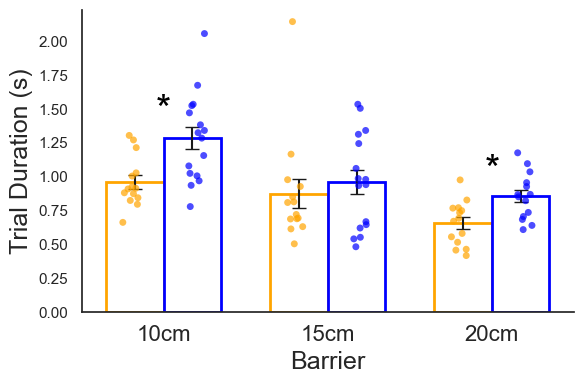

In [3316]:
# 1. Calculate p-values
experiments = analysis_df['experiment_name'].unique()
p_values = []
experiment_labels = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment_name'] == exp]
    control = subset[subset['condition'] == 'Control']['avg_trial_duration']
    cnsds = subset[subset['condition'] == 'CNSDS']['avg_trial_duration']
    
    if len(control) > 1 and len(cnsds) > 1:
        stat, p = ttest_ind(control, cnsds)
        p_values.append(p)
        experiment_labels.append(exp)
    else:
        p_values.append(None)
        experiment_labels.append(exp)

# Apply Bonferroni correction
valid_pvals = [p for p in p_values if p is not None]
reject, corrected_pvals, _, _ = smm.multipletests(valid_pvals, method='bonferroni')
pval_results = dict(zip([e for e, p in zip(experiment_labels, p_values) if p is not None], zip(corrected_pvals, reject)))

# 2. Create the plot
plt.figure(figsize=(6, 4))

analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)
palette = {'Control': 'orange', 'CNSDS': 'blue'}

# Calculate means and SEMs for manual bar plotting
summary = (
    analysis_df
    .groupby(['experiment_name', 'condition'])['avg_trial_duration']
    .agg(['mean', 'sem'])
    .reset_index()
)

# Bar positions
x_labels = ['10cm', '15cm', '20cm']
x_positions = range(len(x_labels))
bar_width = 0.35

for i, exp in enumerate(experiments):
    for j, cond in enumerate(['Control', 'CNSDS']):
        row = summary[(summary['experiment_name'] == exp) & (summary['condition'] == cond)]
        if not row.empty:
            y = row['mean'].values[0]
            yerr = row['sem'].values[0]
            xpos = i - bar_width / 2 if cond == 'Control' else i + bar_width / 2
            color = palette[cond]
            plt.bar(
                xpos, y, width=bar_width, yerr=yerr,
                facecolor='white', edgecolor=color, linewidth=2,
                capsize=5
            )

# Stripplot for individual data points
sns.stripplot(
    data=analysis_df, x='experiment_name', y='avg_trial_duration', hue='condition',
    palette=palette, dodge=True, jitter=True, marker='o', alpha=0.7, legend = False
)

# #Fix legend
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title='Condition')

# Add asterisks for significance
y_max = analysis_df['avg_trial_duration'].max()
bar_offset = 0.2 * y_max
# for i, exp in enumerate(experiments):
#     if exp in pval_results:
#         pval, significant = pval_results[exp]
#         if significant:
#             plt.text(i, y_max + bar_offset, '*', ha='center', va='bottom', fontsize=16, color='black')

for i, exp in enumerate(experiments):
    if exp in pval_results:
        pval, significant = pval_results[exp]
        if significant:
            # Find max bar height for this experiment (across conditions)
            max_bar = summary[summary['experiment_name'] == exp]['mean'].max()
            # Place asterisk a bit above this max bar, adjust offset here
            bar_offset = 0.05 * max_bar  # smaller offset → moves asterisk closer to bar
            
            plt.text(i, max_bar + bar_offset, '*', ha='center', va='bottom', fontsize=28, color='black')


# X-axis and formatting
plt.xticks(ticks=x_positions, labels=x_labels, fontsize = 16)
plt.ylabel('Trial Duration (s)', fontsize = 18)
plt.xlabel('Barrier', fontsize = 18)
plt.ylim(0, y_max + 2 * bar_offset)

plt.tight_layout()

# Remove top and right spines
sns.despine(top=True, right=True)
plt.savefig("trial_duration.pdf", format="pdf")

plt.show()


# Import DLC Files

In [3319]:
# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each file and import its contents
for file in dlc_files:
    try:
        # Read the HDF file
        df = pd.read_hdf(file)
        
        # Append to the list of DataFrames
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading file {file}: {e}")

# Concatenate all the DataFrames into a single DataFrame
if dataframes:
    pts = pd.concat(dataframes, ignore_index=True)
    print("Successfully concatenated DLC files into a single DataFrame.")
else:
    pts = pd.DataFrame()  # If no files are read successfully
    print("No valid DLC files were imported.")

# # Display the concatenated DataFrame
# print(pts.head())

Successfully concatenated DLC files into a single DataFrame.


In [3320]:
pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]

In [3321]:
# Function to extract metadata from filename
def extract_metadata_from_filename(filename):
    # Extract trial number
    trial_match = re.search(r'_(\d+)DLC', filename)
    trial = int(trial_match.group(1)) + 1 if trial_match else None  # Convert to 1-based indexing
    
    # Extract experiment name (handles multiple formats)
    experiment_match = re.search(r'Barrier_Testing__?(\d+cm)_(Day(?:_1|1))', filename, re.IGNORECASE)
    experiment = f"Barrier_Testing_{experiment_match.group(1)}_Day_1" if experiment_match else None  # Standardize name
    
    # Extract subject ID (e.g., WT123 or MCN456)
    subject_match = re.search(r'(WT\d+|MCN\d+)', filename)
    subject = subject_match.group(1) if subject_match else None

    # Extract condition (e.g., CNSDS or Control)
    condition_match = re.search(r'(CNSDS|Control)', filename, re.IGNORECASE)
    condition = condition_match.group(1) if condition_match else None
    
    return trial, experiment, subject, condition

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each file and import its contents
for file in dlc_files:
    try:
        # Read the HDF file
        df = pd.read_hdf(file)

        # Extract metadata from the filename
        trial, experiment, subject, condition = extract_metadata_from_filename(os.path.basename(file))
        
        # Add metadata columns to the DataFrame
        df['trial'] = trial
        df['experiment'] = experiment
        df['subject'] = subject
        df['condition'] = condition

        # Append to the list of DataFrames
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading file {file}: {e}")

# Concatenate all the DataFrames into a single DataFrame
if dataframes:
    pts = pd.concat(dataframes, ignore_index=True)
    print("Successfully concatenated DLC files into a single DataFrame.")
else:
    pts = pd.DataFrame()  # If no files are read successfully
    print("No valid DLC files were imported.")

# Simplify hierarchical column names (collapse the hierarchy)
pts.columns = [' '.join(col[1:3]).strip() for col in pts.columns.values]

# Display the concatenated DataFrame
print(pts.head())


Successfully concatenated DLC files into a single DataFrame.
   Maze_Center x  Maze_Center y  Maze_Center likelihood      Nose x  \
0     701.324158     213.887344                0.979254  704.588867   
1     701.326416     214.029877                0.977822  704.711670   
2     701.401733     214.173889                0.977686  704.779297   
3     701.326416     214.173889                0.980646  704.779297   
4     701.326416     214.173889                0.979866  704.779297   

       Nose y  Nose likelihood  Right_Ear x  Right_Ear y  \
0  732.099976         0.983530   722.632324   756.030640   
1  732.099976         0.984463   722.884888   756.030640   
2  732.099976         0.990444   724.357849   756.030640   
3  717.377258         0.997883   724.449707   744.604004   
4  701.130859         0.998654   727.348816   733.282166   

   Right_Ear likelihood  Left_Ear x  ...  Back_Left_Leg x  Back_Left_Leg y  \
0              0.766178  695.441406  ...       690.911682       878.66766

In [3322]:
pts.columns = list(pts.columns[:-4]) + ['trial', 'experiment', 'subject', 'condition']

In [3323]:
# Step 1: Convert 'experiment', 'trial', and 'subject' columns to strings (if they aren't already)
pts['experiment'] = pts['experiment'].astype(str)
pts['trial'] = pts['trial'].astype(str)
pts['subject'] = pts['subject'].astype(str)

#summary_df['experiment_name'] = summary_df['experiment_name'].astype(str)
#summary_df['trial'] = summary_df['trial'].astype(str)
#summary_df['subject'] = summary_df['subject'].astype(str)

# Step 2: Clean the 'experiment', 'trial', and 'subject' columns (strip spaces)
pts['experiment'] = pts['experiment'].str.strip()
pts['trial'] = pts['trial'].str.strip()
pts['subject'] = pts['subject'].str.strip()

#summary_df['experiment_name'] = summary_df['experiment_name'].str.strip()
#summary_df['trial'] = summary_df['trial'].str.strip()
#summary_df['subject'] = summary_df['subject'].str.strip()

# Step 3: Check unique values to verify they match (optional, just for debugging)
print("Unique experiment values in pts:", pts['experiment'].unique())
#print("Unique experiment values in summary_df:", summary_df['experiment_name'].unique())


Unique experiment values in pts: ['Barrier_Testing_10cm_Day_1' 'Barrier_Testing_15cm_Day_1'
 'Barrier_Testing_20cm_Day_1']


# Create Merged DF

In [3324]:
pts['experiment'] = pts['experiment'].replace({
    'Barrier_Testing__10cm_Day_1': 'Barrier_Testing_10cm_Day_1',
    'Barrier_Testing_20cm_Day1': 'Barrier_Testing_20cm_Day_1',
    'barrier_testing_20cm_day_1': 'Barrier_Testing_20cm_Day_1'
})

In [3325]:
pts['experiment'] = pts['experiment'].replace({
    'Barrier_Testing_10cm_Day_1': '10cm_Barrier',
    'Barrier_Testing_15cm_Day_1': '15cm_Barrier',
    'Barrier_Testing_20cm_Day_1': '20cm_Barrier'
})

In [3326]:
# Rename 'experiment_name' to 'experiment' in summary_df
#summary_df.rename(columns={'experiment_name': 'experiment'}, inplace=True)
analysis_df.rename(columns={'experiment_name': 'experiment'}, inplace=True)

# Step 4: Merge the dataframes on 'experiment', 'trial', and 'subject'
#merged_df = pd.merge(pts, summary_df, on=['experiment', 'trial', 'subject'], how='left')

# Step 5: Check the merged DataFrame
#print(merged_df.head())

# Calculate avg location

In [3327]:
# Replace spaces with underscores in all column names
pts.columns = pts.columns.str.replace(' ', '_')

# Verify the updated column names
print(pts.columns)

Index(['Maze_Center_x', 'Maze_Center_y', 'Maze_Center_likelihood', 'Nose_x',
       'Nose_y', 'Nose_likelihood', 'Right_Ear_x', 'Right_Ear_y',
       'Right_Ear_likelihood', 'Left_Ear_x', 'Left_Ear_y',
       'Left_Ear_likelihood', 'Middle_Neck_x', 'Middle_Neck_y',
       'Middle_Neck_likelihood', 'Middle_Spine_x', 'Middle_Spine_y',
       'Middle_Spine_likelihood', 'Tail_Base_x', 'Tail_Base_y',
       'Tail_Base_likelihood', 'Tail_Mid_x', 'Tail_Mid_y',
       'Tail_Mid_likelihood', 'Tail_End_x', 'Tail_End_y',
       'Tail_End_likelihood', 'Front_Left_Leg_x', 'Front_Left_Leg_y',
       'Front_Left_Leg_likelihood', 'Front_Right_Leg_x', 'Front_Right_Leg_y',
       'Front_Right_Leg_likelihood', 'Back_Left_Leg_x', 'Back_Left_Leg_y',
       'Back_Left_Leg_likelihood', 'Back_Right_Leg_x', 'Back_Right_Leg_y',
       'Back_Right_Leg_likelihood', 'trial', 'experiment', 'subject',
       'condition'],
      dtype='object')


In [3329]:
# Now, proceed with your logic to compute the averages
body_parts = ['Nose_', 'Right_Ear_', 'Left_Ear_', 'Middle_Neck_', 'Middle_Spine_', 
              'Tail_Base_', 'Tail_Mid_', 'Tail_End_', 'Front_Left_Leg_', 
              'Front_Right_Leg_', 'Back_Left_Leg_', 'Back_Right_Leg_']

coordinates = ['x', 'y']
likelihood_suffix = 'likelihood'

avg_x = []
avg_y = []

# Loop through each row of the DataFrame
for index, row in pts.iterrows():
    x_vals = []
    y_vals = []
    
    # Loop through each body part
    for part in body_parts:
        x_col = f"{part}x"
        y_col = f"{part}y"
        likelihood_col = f"{part}{likelihood_suffix}"
        
        # Check if the likelihood for this body part is greater than 0.7
        if row[likelihood_col] > 0.7:  # Assuming 0.7 is the threshold for likelihood
            x_vals.append(row[x_col])
            y_vals.append(row[y_col])
    
    # Exclude 'Maze_Center' columns
    if 'Maze_Center_x' in pts.columns and 'Maze_Center_y' in pts.columns:
        maze_center_x = row.get('Maze_Center_x', None)
        maze_center_y = row.get('Maze_Center_y', None)
        if maze_center_x and maze_center_y:
            # Remove the maze center values if present
            x_vals = [val for val in x_vals if val != maze_center_x]
            y_vals = [val for val in y_vals if val != maze_center_y]

    # Calculate the average of x and y coordinates (if there are valid points)
    if x_vals:
        avg_x.append(sum(x_vals) / len(x_vals))  # Average of x coordinates
        avg_y.append(sum(y_vals) / len(y_vals))  # Average of y coordinates
    else:
        avg_x.append(None)  # If no valid points, append None
        avg_y.append(None)

# Append the average columns to the DataFrame
pts['avg_x'] = avg_x
pts['avg_y'] = avg_y

# Calculate velocities

In [3332]:
# Constants
frame_rate = 60  # frames per second

# Scaling factors (convert pixels to cm)
scale_x = 7.62 / 230
scale_y = 38.735 / 885
scale_velocity = np.sqrt(scale_x**2 + scale_y**2)

# Sort pts to ensure correct frame order
pts_sorted = pts.sort_values(by=['experiment', 'subject', 'trial']).copy()

# Initialize column for per-frame velocity
pts_sorted['velocity_cm'] = np.nan

# Container for trial-level mean velocities
velocity_records = []

# Group by experiment → subject → trial
grouped = pts_sorted.groupby(['experiment', 'subject', 'trial'])

for (experiment, subject, trial), group in grouped:
    group = group.reset_index()  # keep original indices
    original_indices = group['index'].tolist()

    velocities_cm = [np.nan]  # First frame has no previous frame

    for i in range(1, len(group)):
        x1, y1 = group.loc[i - 1, ['avg_x', 'avg_y']]
        x2, y2 = group.loc[i, ['avg_x', 'avg_y']]

        # Distance in pixels
        distance_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        # Distance in cm
        distance_cm = distance_pixels * scale_velocity

        # Velocity in cm/s
        velocity_cm = distance_cm / (1 / frame_rate)

        velocities_cm.append(velocity_cm)

    # Update the main DataFrame with computed velocities
    pts_sorted.loc[original_indices, 'velocity_cm'] = velocities_cm

    # Record mean velocity for the trial (excluding NaN)
    mean_velocity = np.nanmean(velocities_cm)
    velocity_records.append({
        'experiment': experiment,
        'subject': subject,
        'trial': trial,
        'mean_velocity_cm': mean_velocity
    })

# Create a DataFrame with per-trial mean velocities
velocity_df = pd.DataFrame(velocity_records)

# Calculate subject-level average velocity across trials
subject_avg_velocity = (
    velocity_df
    .groupby(['experiment', 'subject'])['mean_velocity_cm']
    .mean()
    .reset_index()
    .rename(columns={'mean_velocity_cm': 'avg_velocity_across_trials'})
)

# Optional: overwrite pts with updated version
pts = pts_sorted


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\1902230234.py:46: RuntimeWarning: Mean of empty slice
  mean_velocity = np.nanmean(velocities_cm)


In [3337]:
# Remove "_Day1" from the 'experiment' column
analysis_df['experiment'] = analysis_df['experiment'].str.replace('_Day1', '', regex=False)


In [3338]:
analysis_df = analysis_df.merge(
    subject_avg_velocity,
    left_on=['experiment', 'subject'],
    right_on=['experiment', 'subject'],
    how='left'
)


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\4086330267.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subject_avg_velocity


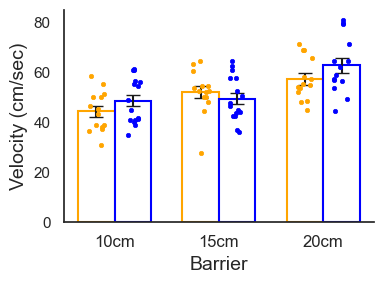

In [3441]:
# Add condition info if not present
# Assuming you have a mapping from subject to condition
if 'condition' not in subject_avg_velocity.columns:
    subject_conditions = analysis_df[['experiment', 'subject', 'condition']].drop_duplicates()
    subject_avg_velocity = subject_avg_velocity.merge(subject_conditions, on=['experiment', 'subject'], how='left')

# Clean up experiment names
subject_avg_velocity['experiment'] = subject_avg_velocity['experiment'].str.replace('_Barrier', '', regex=False)

# Set plot style
sns.set_style("white")

# Color palette
palette = {
    "Control": "orange",
    "CNSDS": "blue"
}

# Calculate group stats (mean and SEM)
group_stats = (
    subject_avg_velocity
    .groupby(['experiment', 'condition'])['avg_velocity_across_trials']
    .agg(['mean', 'sem'])
    .reset_index()
)

experiments = group_stats['experiment'].unique()
conditions = ['Control', 'CNSDS']

# Set up figure
plt.figure(figsize=(4, 3))
bar_width = 0.35
x = range(len(experiments))

# Plot bars
for i, condition in enumerate(conditions):
    color = palette[condition]
    means = []
    sems = []

    for exp in experiments:
        row = group_stats[(group_stats['experiment'] == exp) & (group_stats['condition'] == condition)]
        if not row.empty:
            means.append(row['mean'].values[0])
            sems.append(row['sem'].values[0])
        else:
            means.append(np.nan)
            sems.append(np.nan)

    bar_positions = [xi + (i - 0.5) * bar_width for xi in x]
    plt.bar(
        bar_positions,
        means,
        yerr=sems,
        capsize=5,
        width=bar_width,
        edgecolor=color,
        facecolor='white',
        linewidth=1.5,
        label=condition,
        zorder=2
    )

    # Overlay individual subject points
    for j, exp in enumerate(experiments):
        subject_points = subject_avg_velocity[
            (subject_avg_velocity['experiment'] == exp) &
            (subject_avg_velocity['condition'] == condition)
        ]

        jitter_strength = 0.08
        x_jittered = bar_positions[j] + np.random.uniform(-jitter_strength, jitter_strength, size=len(subject_points))

        plt.scatter(
            x_jittered,
            subject_points['avg_velocity_across_trials'],
            facecolor=color,
            edgecolor=color,
            alpha=1,
            zorder=3,
            linewidth=0.5,
            s=10,
            marker='o'
        )

# Axis and style
plt.xticks(x, experiments, fontsize=12)
plt.ylabel("Velocity (cm/sec)", fontsize=14)
plt.xlabel("Barrier", fontsize=14)
#plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig("velocity.pdf", format="pdf")
plt.show()


In [3341]:
# Normalize the avg_x and avg_y coordinates around the Maze_Center_x and Maze_Center_y columns
pts['normalized_x'] = pts['avg_x'] - pts['Maze_Center_x']
pts['normalized_y'] = pts['avg_y'] - pts['Maze_Center_y']

C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\705637336.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pts.groupby(['condition', 'y_bin'])


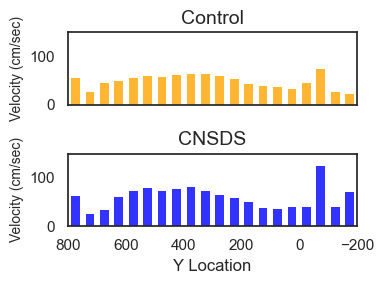

In [3445]:
# Step 1: Bin the normalized Y location into bins (adjust bin edges as needed)
bin_edges = range(-200, 850, 50)  # example bins every 50 units from -200 to 800
pts['y_bin'] = pd.cut(pts['normalized_y'], bins=bin_edges, labels=range(-175, 825, 50))

# Step 2: Calculate average velocity at each y_bin per condition
binned = (
    pts.groupby(['condition', 'y_bin'])
    .agg(avg_velocity_cm=('velocity_cm', 'mean'))
    .reset_index()
)

# Step 3: Prepare plot
fig, axs = plt.subplots(2, 1, figsize=(4, 3), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

colors = {'Control': 'orange', 'CNSDS': 'blue'}
conditions = ['Control', 'CNSDS']

for i, condition in enumerate(conditions):
    ax = axs[i]
    data = binned[binned['condition'] == condition].sort_values('y_bin')
    
    # Convert y_bin labels to floats for plotting on x-axis
    x_vals = data['y_bin'].astype(float)
    y_vals = data['avg_velocity_cm']

    ax.bar(
        x_vals,
        y_vals,
        width=30,
        color=colors[condition],
        alpha=0.8,
        edgecolor='none'
    )
    ax.set_ylabel('Velocity (cm/sec)', fontsize=10)
    ax.set_title(condition, fontsize=14)
    ax.grid(False)
    ax.set_ylim(0, 150)

# Shared x-axis label
axs[-1].set_xlabel('Y Location', fontsize=12)
axs[-1].set_xlim(800, -200)

plt.tight_layout()
plt.savefig("D:/Figures/velocity_by_y_location.pdf", format="pdf")
plt.show()


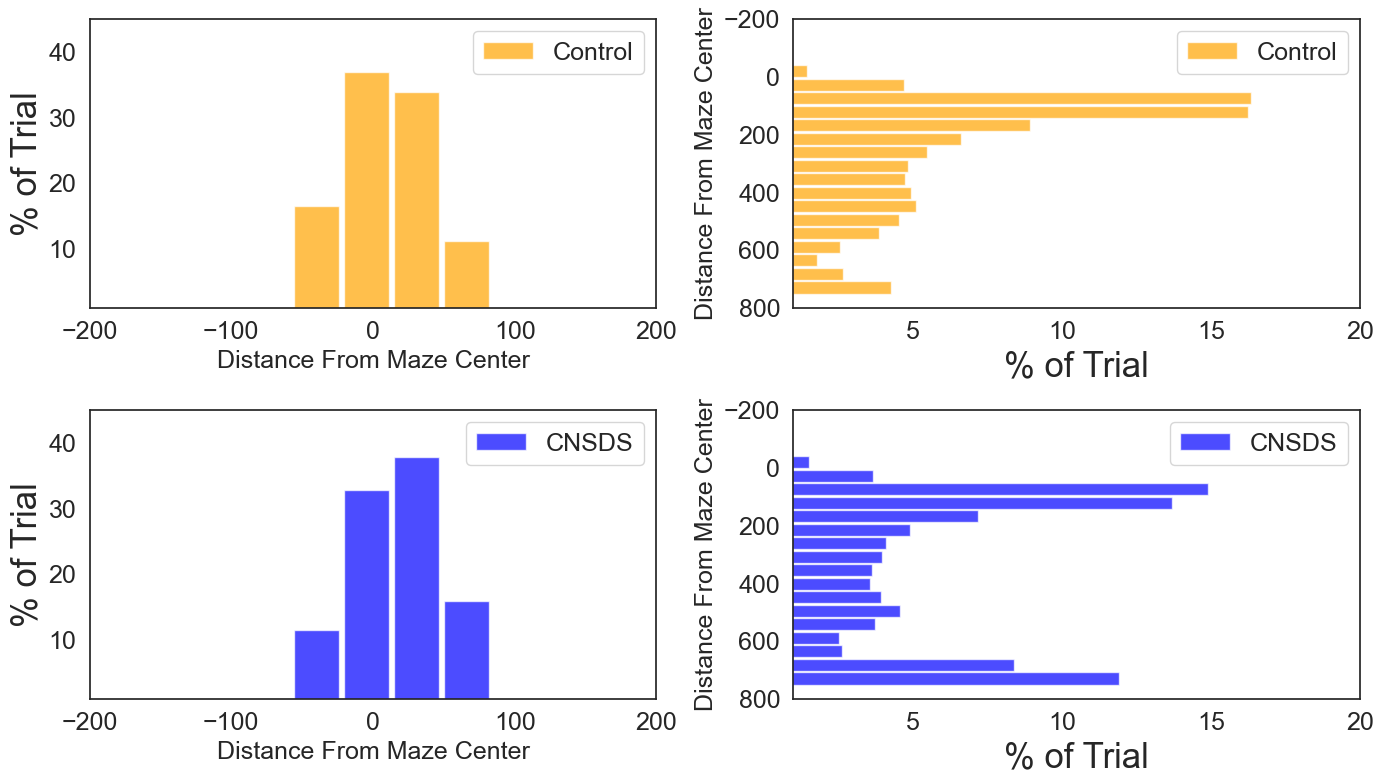

In [3433]:
import matplotlib.pyplot as plt
import numpy as np

# Assume pts is your DataFrame and conditions is a list of the two conditions, e.g.:
# conditions = ['CNSDS', 'Control']

# Combine data for bin edges
combined_data_x = pts['normalized_x'].dropna()
combined_data_y = pts['normalized_y'].dropna()

# Define number of bins
bins = 30
bin_edges_x = np.linspace(combined_data_x.min(), combined_data_x.max(), bins + 1)
bin_edges_y = np.linspace(combined_data_y.min(), combined_data_y.max(), bins + 1)

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, condition in enumerate(conditions):
    # Get data for current condition
    condition_data_x = pts[pts['condition'] == condition]['normalized_x'].dropna()
    condition_data_y = pts[pts['condition'] == condition]['normalized_y'].dropna()

    # Calculate weights for percentage histograms
    weights_x = np.ones_like(condition_data_x) / len(condition_data_x) * 100
    weights_y = np.ones_like(condition_data_y) / len(condition_data_y) * 100

    # --- X-coordinate histogram (vertical bars) ---
    ax_x = axs[i, 0]
    ax_x.hist(condition_data_x, bins=bin_edges_x, weights=weights_x,
              alpha=0.7,
              color='blue' if condition == 'CNSDS' else 'orange',
              histtype='bar', rwidth=0.9)
    ax_x.set_xlabel('Distance From Maze Center', fontsize=18)
    ax_x.set_ylabel('% of Trial', fontsize=25)
    ax_x.tick_params(axis='both', labelsize=18)
    ax_x.set_ylim(1, 45)
    ax_x.set_xlim(-200, 200)
    ax_x.grid(False)
    ax_x.legend([condition], loc='upper right', fontsize=18)

    # --- Y-coordinate histogram (horizontal bars) ---
    ax_y = axs[i, 1]
    ax_y.hist(condition_data_y, bins=bin_edges_y, weights=weights_y,
              alpha=0.7,
              color='blue' if condition == 'CNSDS' else 'orange',
              histtype='bar', rwidth=0.9,
              orientation='horizontal')  # ✅ Horizontal bars
    ax_y.set_xlabel('% of Trial', fontsize=25)
    ax_y.set_ylabel('Distance From Maze Center', fontsize=18)
    ax_y.tick_params(axis='both', labelsize=18)
    ax_y.set_xlim(1, 20)
    ax_y.set_ylim(800, -200)
    ax_y.grid(False)
    ax_y.legend([condition], loc='upper right', fontsize=18)

# Final layout and save
plt.tight_layout()
plt.savefig("location_histogram.pdf", format="pdf")
plt.show()



# Locations scatterplot

In [3349]:
summary_df_copy=summary_df

In [3350]:
pts_copy=pts

In [3351]:
# Deduplicate summary_df_copy to ensure one row per subject
summary_unique = summary_df_copy[['subject', 'HR_Arm']].drop_duplicates(subset='subject')

# Merge without duplicating pts_copy
pts = pts_copy.copy()
pts['HR_Arm'] = pts['subject'].map(summary_unique.set_index('subject')['HR_Arm'])


## get an example image frame from a video for plotting

True
Index(['Maze_Center x', 'Maze_Center y', 'Maze_Center likelihood', 'Nose x',
       'Nose y', 'Nose likelihood', 'Right_Ear x', 'Right_Ear y',
       'Right_Ear likelihood', 'Left_Ear x', 'Left_Ear y',
       'Left_Ear likelihood', 'Middle_Neck x', 'Middle_Neck y',
       'Middle_Neck likelihood', 'Middle_Spine x', 'Middle_Spine y',
       'Middle_Spine likelihood', 'Tail_Base x', 'Tail_Base y',
       'Tail_Base likelihood', 'Tail_Mid x', 'Tail_Mid y',
       'Tail_Mid likelihood', 'Tail_End x', 'Tail_End y',
       'Tail_End likelihood', 'Front_Left_Leg x', 'Front_Left_Leg y',
       'Front_Left_Leg likelihood', 'Front_Right_Leg x', 'Front_Right_Leg y',
       'Front_Right_Leg likelihood', 'Back_Left_Leg x', 'Back_Left_Leg y',
       'Back_Left_Leg likelihood', 'Back_Right_Leg x', 'Back_Right_Leg y',
       'Back_Right_Leg likelihood'],
      dtype='object')


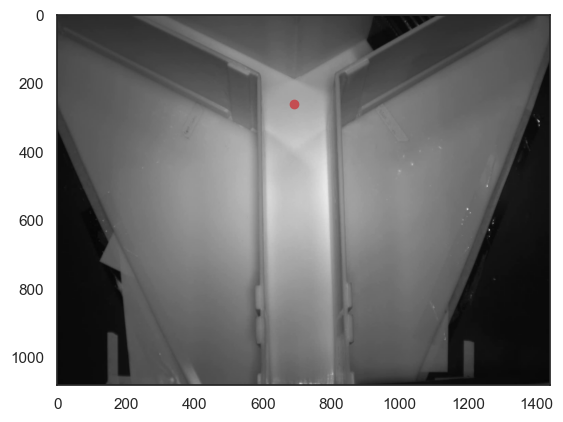

In [3352]:
vid_pic_file = r'C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1\05052024\WT045\050524_Barrier_Testing_10cm_Day_1_WT045FCNSDS_StartArm_3.avi'
vid = cv2.VideoCapture(vid_pic_file)
vid.set(cv2.CAP_PROP_POS_FRAMES,170)
ret, frame = vid.read()
print(ret)

vid.release()

plt.imshow(frame)

vid_dlc_file = r'C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1\05052024\WT045\050524_Barrier_Testing_10cm_Day_1_WT045FCNSDS_StartArm_3DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_filtered.h5'
dlc_df = pd.read_hdf(vid_dlc_file)
dlc_df.columns = [' '.join(col[:][1:3]).strip() for col in dlc_df.columns.values]
print(dlc_df.keys())
low_like = dlc_df['Maze_Center likelihood']<0.9
x = dlc_df['Maze_Center x']
x[low_like]=np.nan
x_pic = int(np.nanmean(x))
y = dlc_df['Maze_Center y']
y[low_like]=np.nan
y_pic = int(np.nanmean(y))
plt.plot(x_pic,y_pic,'ro')

# plt.figure()
# frame_2 = np.roll(a=frame,shift=-x_pic,axis=0)
# frame_2 = np.roll(a=frame_2,shift=-y_pic,axis=1)
# plt.imshow(frame_2)

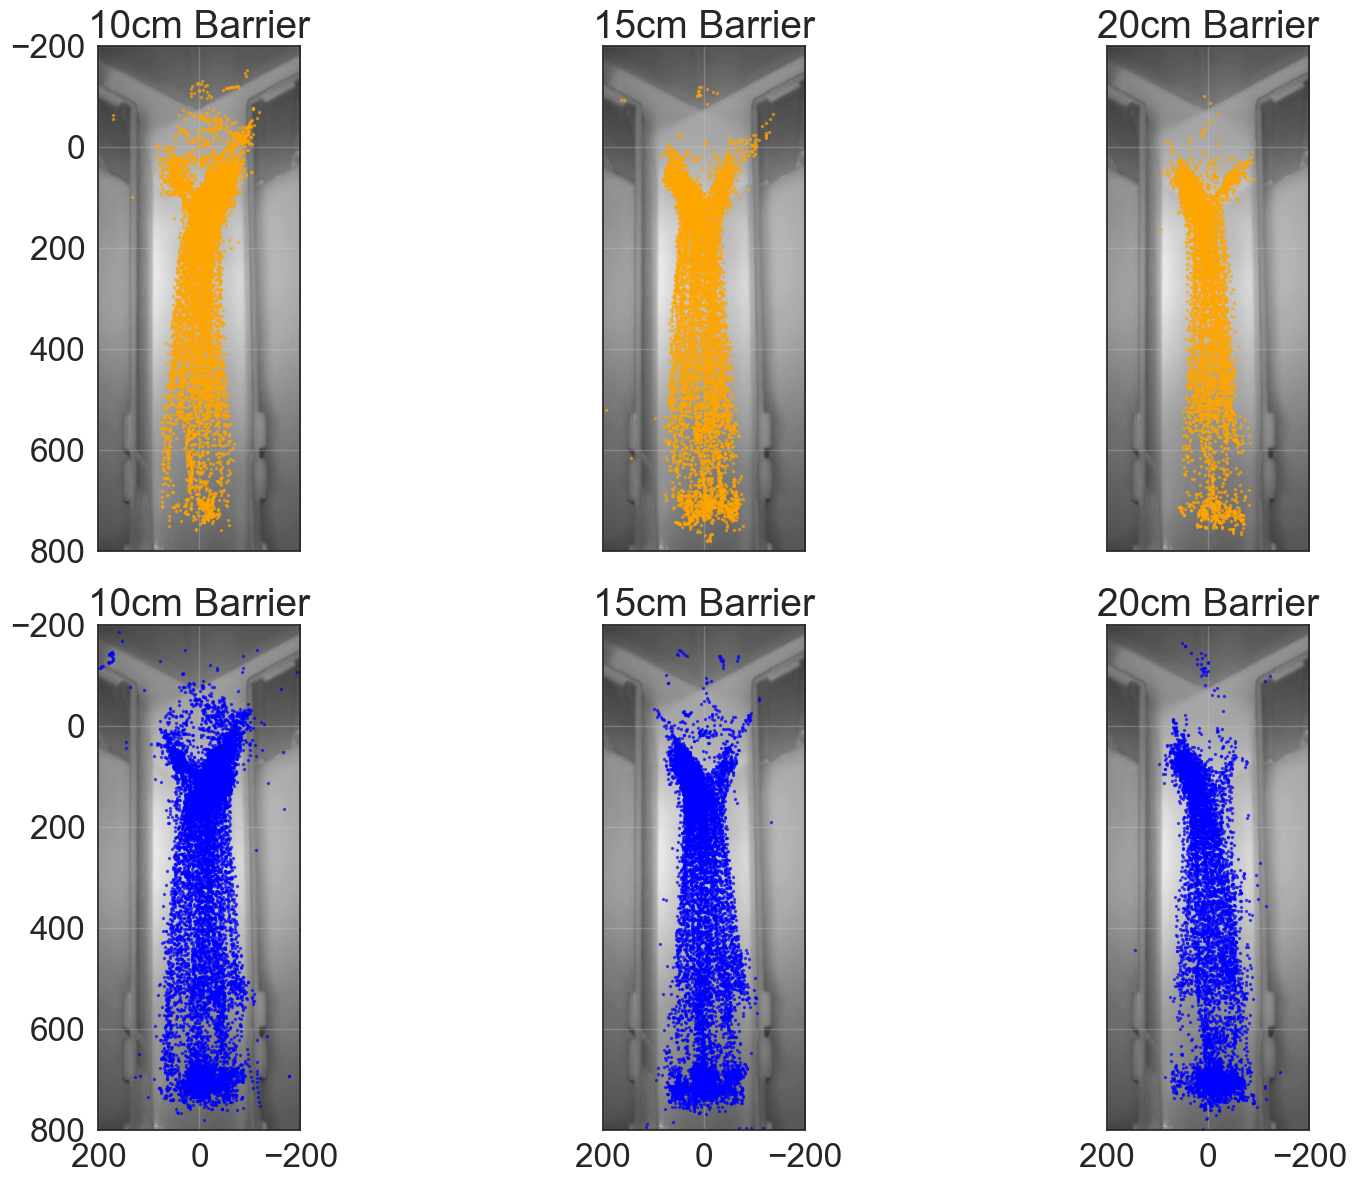

In [3353]:
# Get unique conditions and experiments
conditions = ['Control', 'CNSDS']
barrier = pts['experiment'].unique()

# Create a figure with subplots for each condition and experiment
fig, axes = plt.subplots(len(conditions), len(barrier), figsize=(18, 12), sharex=True, sharey=True)
fig.subplots_adjust(
    left=0.05,    # left margin
    right=0.95,   # right margin
    top=0.95,     # top margin
    bottom=0.05,  # bottom margin
    wspace=0.0,   # horizontal space between subplots (default ~0.2)
    hspace=0.1    # vertical space between subplots (default ~0.2)
)

# Always treat axes as a 2D array
if len(conditions) == 1:
    axes = axes[np.newaxis, :]
if len(barrier) == 1:
    axes = axes[:, np.newaxis]

# Iterate over the conditions and experiments
for row, condition in enumerate(conditions):
    for col, experiment in enumerate(barrier):

        ax = axes[row,col]
        # Filter data for the current condition and experiment
        condition_experiment_data = pts[
            (pts['condition'] == condition) &
            (pts['experiment'] == experiment)
        ].copy()

        # Reflect x-coordinates if HR_Arm is 'right'
        condition_experiment_data.loc[
            condition_experiment_data['HR_Arm'].str.lower() == 'right', 'normalized_x'
        ] *= -1

        # Set color
        color = 'blue' if condition == 'CNSDS' else 'orange'

        # plot image
        height, width, chan = frame.shape
        extent = [-x_pic, width - x_pic, height - y_pic, -y_pic]
        # Rotation angle in degrees
        angle = 2  # counter-clockwise
        # Create transform
        transform = Affine2D().rotate_deg_around(0, 0, angle) + ax.transData
        ax.imshow(frame, extent=extent, origin='upper', transform=transform)
        
        # Scatter plot
        ax.scatter(
            condition_experiment_data['normalized_x'],
            condition_experiment_data['normalized_y'],
            alpha=0.6, marker='o', color=color, s=2, label=condition
        )

        # Title by barrier height
        if col == 0:
            title = '10cm Barrier'
        elif col == 1:
            title = '15cm Barrier'
        else:
            title = '20cm Barrier'

        # Axis labels, titles, and formatting
        ax.set_title(title, fontsize=28)
        #ax.set_xlabel('Normalized X Coordinates', fontsize=25)
        #ax.set_ylabel('Normalized Y Coordinates', fontsize=25)
        ax.set_xlim(200, -200)
        ax.set_ylim(800, -200)
        ax.tick_params(axis='both', labelsize=24)
        ax.grid(True, alpha=0.3)
        # ax.axis('square')
        # ax.legend(loc='upper right', fontsize=22, markerscale=8)

# Final layout and export
plt.tight_layout()
plt.savefig("location_scatterplot.pdf", format="pdf")
plt.show()


# Time Spent in Start Box

In [3356]:
# Remove "_Day1" from the 'experiment' column
analysis_df['experiment'] = analysis_df['experiment'].str.replace('_Barrier', '', regex=False)



In [3357]:
pts['experiment'] = pts['experiment'].str.replace('_Barrier', '', regex=False)


In [3358]:
# 1. Count total frames per experiment, subject, and trial
total_frames_per_trial = (
    pts.groupby(['experiment', 'subject', 'trial'])
    .size()
    .reset_index(name='total_frames')
)

# 2. Filter frames in the start box
start_box_df = pts[(pts['normalized_y'] >= 600) & (pts['normalized_y'] <= 800)]

# 3. Count start box frames per experiment, subject, and trial
start_box_frames_per_trial = (
    start_box_df.groupby(['experiment', 'subject', 'trial'])
    .size()
    .reset_index(name='start_box_frames')
)

# 4. Merge frame counts
merged = pd.merge(
    total_frames_per_trial,
    start_box_frames_per_trial,
    on=['experiment', 'subject', 'trial'],
    how='left'
)
merged['start_box_frames'] = merged['start_box_frames'].fillna(0)

# 5. Compute proportion and drop NaNs
merged['start_box_proportion'] = merged['start_box_frames'] / merged['total_frames']
merged = merged.dropna(subset=['start_box_proportion'])

# 6. Average per subject and experiment
avg_start_box_time = (
    merged.groupby(['experiment', 'subject'])['start_box_proportion']
    .mean()
    .reset_index(name='avg_start_box_time')
)

# 7. Merge into analysis_df
analysis_df = analysis_df.merge(
    avg_start_box_time,
    on=['experiment', 'subject'],
    how='left'
)


In [3365]:
# Step 1: Compute average trial duration (in frames) per subject
avg_total_frames = (
    pts.groupby(['experiment', 'subject', 'trial'])
    .size()
    .groupby(['experiment', 'subject'])
    .mean()
    .reset_index(name='avg_total_frames')
)

# Step 2: Merge with analysis_df
analysis_df = analysis_df.merge(
    avg_total_frames,
    on=['experiment', 'subject'],
    how='left'
)

# Step 3: Convert avg_start_box_time (proportion) to seconds
# avg_start_box_time_secs = proportion × avg_total_frames ÷ 60
analysis_df['avg_start_box_time_secs'] = (
    analysis_df['avg_start_box_time'] * analysis_df['avg_total_frames'] / 60
)


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\1928351022.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df.groupby(['experiment', 'condition'])['avg_start_box_time_secs']


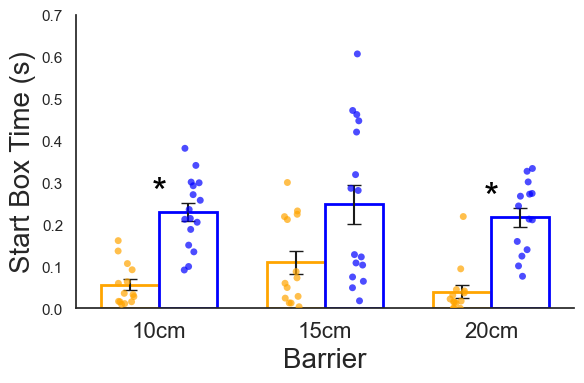

In [3366]:
# Ensure consistent condition order
analysis_df['condition'] = pd.Categorical(
    analysis_df['condition'],
    categories=['Control', 'CNSDS'],  # Control on left
    ordered=True
)

palette = {'Control': 'orange', 'CNSDS': 'blue'}
bar_width = 0.35
experiments = analysis_df['experiment'].unique()

plt.figure(figsize=(6, 4))

# 1. Compute means and SEMs for plotting
summary = (
    analysis_df.groupby(['experiment', 'condition'])['avg_start_box_time_secs']
    .agg(['mean', 'sem'])
    .reset_index()
)

# 2. Draw bars manually (white fill, colored edge)
for i, exp in enumerate(experiments):
    for cond in ['Control', 'CNSDS']:
        row = summary[(summary['experiment'] == exp) & (summary['condition'] == cond)]
        if not row.empty:
            y = row['mean'].values[0]
            yerr = row['sem'].values[0]
            xpos = i - bar_width / 2 if cond == 'Control' else i + bar_width / 2
            plt.bar(
                xpos, y, width=bar_width, yerr=yerr,
                facecolor='white', edgecolor=palette[cond], linewidth=2, capsize=5
            )

# 3. Overlay individual data points
sns.stripplot(
    data=analysis_df,
    x='experiment',
    y='avg_start_box_time_secs',
    hue='condition',
    dodge=True,
    palette=palette,
    jitter=True,
    marker='o',
    alpha=0.7
)

# 4. Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Condition')

# 5. Run t-tests and plot asterisks
p_values = []
exp_labels = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment'] == exp]
    control = subset[subset['condition'] == 'Control']['avg_start_box_time_secs']
    cnsds = subset[subset['condition'] == 'CNSDS']['avg_start_box_time_secs']
    if len(control) > 1 and len(cnsds) > 1:
        stat, p = ttest_ind(control, cnsds, equal_var=False)
        p_values.append(p)
        exp_labels.append(exp)

# Bonferroni correction
reject, corrected_pvals, _, _ = smm.multipletests(p_values, method='bonferroni')
pval_dict = dict(zip(exp_labels, zip(corrected_pvals, reject)))

# Prepare to track the highest point to set y-axis limit
asterisk_positions = []

for i, exp in enumerate(experiments):
    if exp in pval_dict:
        pval, significant = pval_dict[exp]
        if significant:
            y_bar = summary[(summary['experiment'] == exp)]['mean'].max()
            y_asterisk = y_bar + 0.0  # space above bar
            asterisk_positions.append(y_asterisk)
            plt.text(i, y_asterisk, '*', ha='center', va='bottom', fontsize=28, color='black')

# Set the y-limit high enough to show all asterisks
data_max = analysis_df['avg_start_box_time_secs'].max()
asterisk_max = max(asterisk_positions) if asterisk_positions else data_max
plt.ylim(0, 0.7)  # small extra space above


# Final formatting
plt.xticks(ticks=range(len(experiments)), labels=experiments, fontsize=16)
plt.ylabel('Start Box Time (s)', fontsize=20)
plt.xlabel('Barrier', fontsize=20)
sns.despine(top=True, right=True)
plt.legend().remove()

plt.tight_layout()
plt.savefig("startbox_time.pdf", format="pdf")  # Save it first
plt.show()  # Then show it



# Total Distance Traveled

In [3373]:
# 1. Function to calculate total distance per trial
def calculate_total_distance_per_trial(data):
    if len(data) > 1:
        diff_x = np.diff(data['normalized_x'])
        diff_y = np.diff(data['normalized_y'])
        distances = np.sqrt(diff_x**2 + diff_y**2)
        return np.sum(distances)
    return 0

# 2. Calculate total distance per trial
total_distance_per_trial = (
    pts.groupby(['experiment', 'subject', 'trial'])
    .apply(calculate_total_distance_per_trial)
    .reset_index(name='total_distance')
)

# 3. Average distance per experiment and subject
avg_distance_per_subject = (
    total_distance_per_trial
    .groupby(['experiment', 'subject'])['total_distance']
    .mean()
    .reset_index()
    .rename(columns={'total_distance': 'avg_total_distance'})
)

# # ✅ If 'experiment' column isn't in analysis_df yet, create it from 'experiment_name'
# if 'experiment' not in analysis_df.columns and 'experiment' in analysis_df.columns:
#     analysis_df['experiment'] = analysis_df['experiment']

# 4. Merge based on 'experiment' and 'subject'
analysis_df = analysis_df.merge(
    avg_distance_per_subject,
    on=['experiment', 'subject'],
    how='left'
)

# ✅ Final output
print(analysis_df[['experiment', 'subject', 'avg_total_distance']].head())


  experiment subject  avg_total_distance
0       10cm   WT022          844.066948
1       10cm   WT023          994.400577
2       10cm   WT025          977.128911
3       10cm   WT027          884.033310
4       10cm   WT028          672.788698


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\3151719756.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pts.groupby(['experiment', 'subject', 'trial'])


In [3377]:
# Define the conversion factors for both x and y dimensions
scale_x = 7.62 / 230  # Width conversion factor
scale_y = 38.735 / 885  # Height conversion factor

# Convert the total_distance from units to centimeters
analysis_df['total_distance_cm'] = analysis_df['avg_total_distance'] * np.sqrt(scale_x**2 + scale_y**2)

# Verify the updated dataframe with the converted total_distance_cm
#print(analysis_df[['experiment', 'subject', 'trial', 'total_distance', 'total_distance_cm']].head())

C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\1004682221.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df


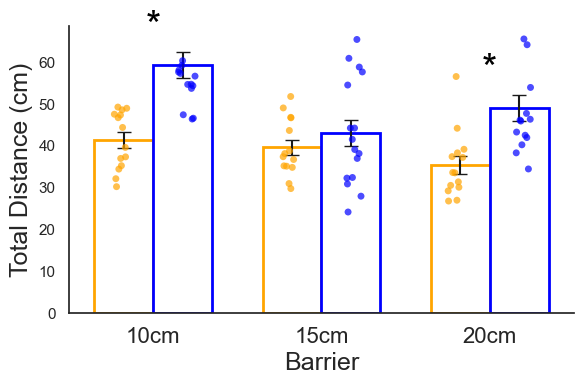

10cm:
  Control   -> mean = 41.29, std = 6.88, n = 14
  CNSDS     -> mean = 59.20, std = 12.12, n = 16
  t = -5.05, df = 24.3, p = 0.0000, corrected p = 0.0001, significant = True

15cm:
  Control   -> mean = 39.59, std = 6.81, n = 14
  CNSDS     -> mean = 43.02, std = 12.77, n = 16
  t = -0.93, df = 23.5, p = 0.3595, corrected p = 1.0000, significant = False

20cm:
  Control   -> mean = 35.32, std = 7.89, n = 14
  CNSDS     -> mean = 48.96, std = 11.75, n = 14
  t = -3.61, df = 22.7, p = 0.0015, corrected p = 0.0045, significant = True



In [3379]:
# ---- 1. Run Welch's t-tests and collect statistics ---- #
experiments = analysis_df['experiment'].unique()
results = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment'] == exp]
    control = subset[subset['condition'] == 'Control']['total_distance_cm']
    cnsds = subset[subset['condition'] == 'CNSDS']['total_distance_cm']

    n1, n2 = len(control), len(cnsds)
    
    if n1 > 1 and n2 > 1:
        t_stat, p = ttest_ind(control, cnsds, equal_var=False)
        s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
        df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

        results.append({
            'experiment': exp,
            't_stat': t_stat,
            'df': df,
            'p_raw': p,
            'n_control': n1,
            'n_cnsds': n2,
            'mean_control': np.mean(control),
            'std_control': np.std(control, ddof=1),
            'mean_cnsds': np.mean(cnsds),
            'std_cnsds': np.std(cnsds, ddof=1)
        })

# ---- 2. Bonferroni correction ---- #
p_vals = [r['p_raw'] for r in results]
reject, corrected_pvals, _, _ = smm.multipletests(p_vals, method='bonferroni')

for i, r in enumerate(results):
    r['p_corrected'] = corrected_pvals[i]
    r['significant'] = reject[i]

# ---- 3. Plot ---- #
plt.figure(figsize=(6, 4))

palette = {'Control': 'orange', 'CNSDS': 'blue'}
bar_width = 0.35

# Calculate means and SEMs manually for styled bar plotting
summary = (
    analysis_df
    .groupby(['experiment', 'condition'])['total_distance_cm']
    .agg(['mean', 'sem'])
    .reset_index()
)

for i, exp in enumerate(experiments):
    for cond in ['Control', 'CNSDS']:
        row = summary[(summary['experiment'] == exp) & (summary['condition'] == cond)]
        if not row.empty:
            y = row['mean'].values[0]
            yerr = row['sem'].values[0]
            xpos = i - bar_width/2 if cond == 'Control' else i + bar_width/2
            plt.bar(
                xpos, y, width=bar_width, yerr=yerr,
                facecolor='white', edgecolor=palette[cond], linewidth=2, capsize=5
            )

# Stripplot for individual data points
sns.stripplot(
    data=analysis_df,
    x='experiment',
    y='total_distance_cm',
    hue='condition',
    palette=palette,
    dodge=True,
    jitter=True,
    alpha=0.7,
    marker='o'
)

# Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Condition')

# Asterisks for significance
y_max = analysis_df['total_distance_cm'].max()
asterisk_offset = 0.05 * y_max
asterisk_positions = []

for i, exp in enumerate(experiments):
    result = next((r for r in results if r['experiment'] == exp), None)
    if result and result['significant']:
        bar_top = summary[(summary['experiment'] == exp)]['mean'].max()
        y_asterisk = bar_top + asterisk_offset
        plt.text(i, y_asterisk, '*', ha='center', va='bottom', fontsize=28, color='black')
        asterisk_positions.append(y_asterisk)

# Set Y-axis limit above highest asterisk
y_limit = max(asterisk_positions) + asterisk_offset if asterisk_positions else y_max + asterisk_offset
plt.ylim(0, y_limit)

# Custom x-axis labels
plt.xticks(
    ticks=range(len(experiments)),
    labels=['10cm', '15cm', '20cm'],
    fontsize=16
)

plt.ylabel("Total Distance (cm)", fontsize=18)
plt.xlabel("Barrier", fontsize=18)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.legend().remove()


plt.savefig("distance.pdf", format="pdf")
plt.show()

# ---- 4. Print statistical results ---- #
for r in results:
    print(
        f"{r['experiment']}:\n"
        f"  Control   -> mean = {r['mean_control']:.2f}, std = {r['std_control']:.2f}, n = {r['n_control']}\n"
        f"  CNSDS     -> mean = {r['mean_cnsds']:.2f}, std = {r['std_cnsds']:.2f}, n = {r['n_cnsds']}\n"
        f"  t = {r['t_stat']:.2f}, df = {r['df']:.1f}, "
        f"p = {r['p_raw']:.4f}, corrected p = {r['p_corrected']:.4f}, "
        f"significant = {r['significant']}\n"
    )


In [3381]:
def parse_and_format_date(x):
    x = str(x).strip()
    if len(x) == 5:
        dt = pd.to_datetime(x, format='%m%d%y', errors='coerce')
    elif len(x) == 7:
        dt = pd.to_datetime(x, format='%m%d%Y', errors='coerce')
    else:
        return pd.NaT

    if pd.notnull(dt):
        # Manually build the string: month without leading zero + day + year
        return f"{dt.month}{dt.strftime('%d%y')}"  # e.g. '31524'
    else:
        return pd.NaT

analysis_df['date'] = analysis_df['date'].apply(parse_and_format_date)

C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\875572774.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_df
C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\875572774.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_df
C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\875572774.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_df



📊 Cohort 1 - Dates: ['31524', '31824', '32124']
  Experiment: 10cm
    Mean (Control): 37.85
    Mean (CNSDS):   56.64
    Raw p-value:    0.0016
    Corrected p:    0.0048
    Significant?:   Yes
  Experiment: 15cm
    Mean (Control): 43.36
    Mean (CNSDS):   53.40
    Raw p-value:    0.0893
    Corrected p:    0.2679
    Significant?:   No
  Experiment: 20cm
    Mean (Control): 31.67
    Mean (CNSDS):   43.98
    Raw p-value:    0.0021
    Corrected p:    0.0063
    Significant?:   Yes
--------------------------------------------------

📊 Cohort 2 - Dates: ['50524', '50824', '51124']
  Experiment: 10cm
    Mean (Control): 41.71
    Mean (CNSDS):   52.84
    Raw p-value:    0.0442
    Corrected p:    0.1327
    Significant?:   No
  Experiment: 15cm
    Mean (Control): 33.93
    Mean (CNSDS):   33.66
    Raw p-value:    0.9233
    Corrected p:    1.0000
    Significant?:   No
  Experiment: 20cm
    Mean (Control): 32.00
    Mean (CNSDS):   58.64
    Raw p-value:    0.0111
    Correct

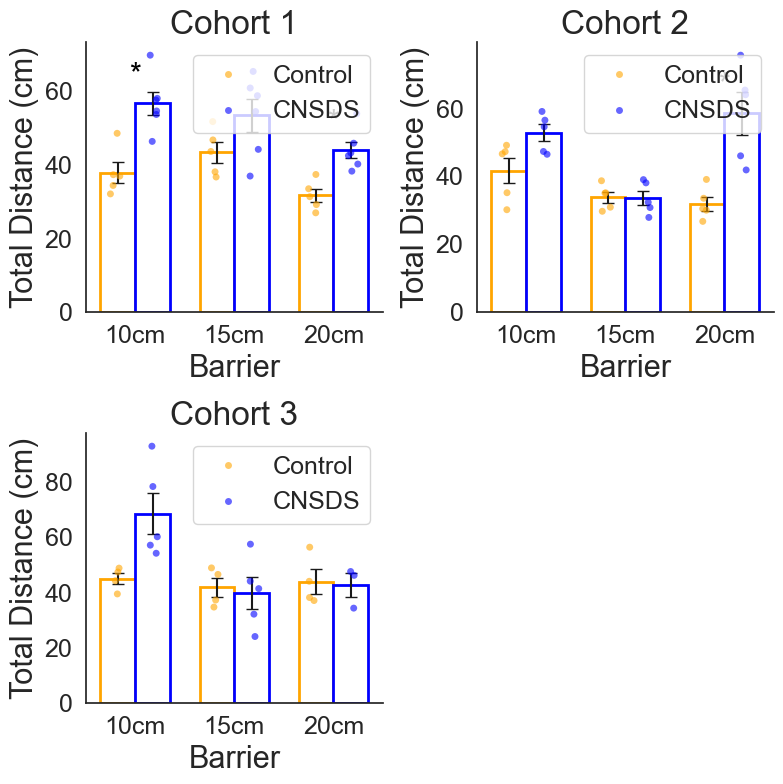

In [3385]:
# Define date cohorts
dates_to_analyze = [
    ['31524', '31824', '32124'],   # Cohort 1
    ['50524', '50824', '51124'],   # Cohort 2
    ['62624', '62924', '70224']    # Cohort 3
]

# Plot setup: 2x2 grid (3 used)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()  # To index 0, 1, 2

palette = {'Control': 'orange', 'CNSDS': 'blue'}
bar_width = 0.35

for idx, cohort_dates in enumerate(dates_to_analyze):
    ax = axes[idx]
    
    cohort_df = analysis_df[analysis_df['date'].isin(cohort_dates)]
    experiments = cohort_df['experiment'].unique()
    
    # Group summary
    summary = (
        cohort_df
        .groupby(['experiment', 'condition'])['total_distance_cm']
        .agg(['mean', 'sem'])
        .reset_index()
    )

    # ---- Run Welch's t-tests ---- #
    results = []
    for exp in experiments:
        subset = cohort_df[cohort_df['experiment'] == exp]
        control = subset[subset['condition'] == 'Control']['total_distance_cm']
        cnsds = subset[subset['condition'] == 'CNSDS']['total_distance_cm']

        if len(control) > 1 and len(cnsds) > 1:
            t_stat, p = ttest_ind(control, cnsds, equal_var=False)
            s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
            n1, n2 = len(control), len(cnsds)
            df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

            results.append({
                'experiment': exp,
                'p_raw': p,
                'mean_control': np.mean(control),
                'mean_cnsds': np.mean(cnsds)
            })

    # ---- Bonferroni correction ---- #
    if results:
        p_vals = [r['p_raw'] for r in results]
        reject, corrected_pvals, _, _ = smm.multipletests(p_vals, method='bonferroni')
        for i, r in enumerate(results):
            r['p_corrected'] = corrected_pvals[i]
            r['significant'] = reject[i]
    # 🖨️ Print statistical results
        print(f"\n📊 Cohort {idx + 1} - Dates: {cohort_dates}")
        for r in results:
            print(f"  Experiment: {r['experiment']}")
            print(f"    Mean (Control): {r['mean_control']:.2f}")
            print(f"    Mean (CNSDS):   {r['mean_cnsds']:.2f}")
            print(f"    Raw p-value:    {r['p_raw']:.4f}")
            print(f"    Corrected p:    {r['p_corrected']:.4f}")
            print(f"    Significant?:   {'Yes' if r['significant'] else 'No'}")
        print("-" * 50)

    # ---- Plot bars ---- #
    for i, exp in enumerate(experiments):
        for cond in ['Control', 'CNSDS']:
            row = summary[(summary['experiment'] == exp) & (summary['condition'] == cond)]
            if not row.empty:
                y = row['mean'].values[0]
                yerr = row['sem'].values[0]
                xpos = i - bar_width / 2 if cond == 'Control' else i + bar_width / 2
                ax.bar(
                    xpos, y, width=bar_width, yerr=yerr,
                    facecolor='white', edgecolor=palette[cond], linewidth=2, capsize=4
                )

    # ---- Plot individual data points ---- #
    sns.stripplot(
        data=cohort_df,
        x='experiment',
        y='total_distance_cm',
        hue='condition',
        palette=palette,
        dodge=True,
        jitter=True,
        alpha=0.6,
        ax=ax
    )

    # ---- Asterisk for significance ---- #
    y_max = cohort_df['total_distance_cm'].max()
    offset = 0.05 * y_max

    for i, r in enumerate(results):
        if r['significant']:
            max_y = max(r['mean_control'], r['mean_cnsds'])
            ax.text(i, max_y + offset, '*', ha='center', va='bottom', fontsize=22, color='black')

    ax.set_title(f'Cohort {idx+1}', fontsize=24)
    ax.set_ylabel("Total Distance (cm)", fontsize = 22)
    ax.set_xlabel("Barrier", fontsize = 22)
    ax.set_xticks(range(len(experiments)))
    ax.set_xticklabels(experiments, fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    #ax.set_ylim(0, y_max + 2 * offset)
    sns.despine(ax=ax, top=True, right=True)
    ax.legend(loc='upper right', fontsize=18)



# Hide unused subplot
axes[3].axis('off')

plt.tight_layout()
plt.savefig("distance_by_cohort.pdf", format="pdf")
plt.show()


# Time Spent in Decision Zone

In [3386]:
# 1. Filter frames in the decision area
decision_area_df = pts[
    (pts['normalized_x'] >= -100) & (pts['normalized_x'] <= 100) &
    (pts['normalized_y'] >= 200) & (pts['normalized_y'] <= 600)
]

# 2. Count frames in decision area per trial
decision_counts = decision_area_df.groupby(['experiment', 'subject', 'trial']).size().reset_index(name='decision_frame_count')

# 3. Convert frame count to time (seconds)
decision_counts['decision_time_secs'] = decision_counts['decision_frame_count'] / 60  # assuming 60 fps

# 4. Average time per subject and experiment across trials
avg_decision_time = decision_counts.groupby(['experiment', 'subject'])['decision_time_secs'].mean().reset_index()
avg_decision_time.rename(columns={'decision_time_secs': 'avg_decision_time_secs'}, inplace=True)

# 5. Merge with analysis_df
analysis_df = analysis_df.merge(
    avg_decision_time,
    on=['experiment', 'subject'],
    how='left'
)


c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


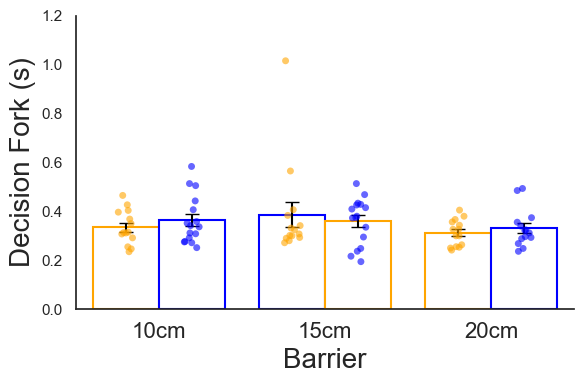

In [3388]:
palette = {'Control': 'orange', 'CNSDS': 'blue'}

plt.figure(figsize=(6, 4))

ax = sns.barplot(
    data=analysis_df,
    x='experiment',
    y='avg_decision_time_secs',
    hue='condition',
    palette=palette,
    errorbar=None,  # disable seaborn automatic error bars
    dodge=True
)

# Set white fill and colored edges for bars
for i, bar in enumerate(ax.patches):
    bar.set_facecolor('white')
    if i % 2 == 0:
        bar.set_edgecolor(palette['Control'])
    else:
        bar.set_edgecolor(palette['CNSDS'])
    bar.set_linewidth(1.5)

# Manually add error bars
experiments = analysis_df['experiment'].unique()
bar_width = 0.8  # total width for both bars in a group
offset = bar_width / 2

for i, exp in enumerate(experiments):
    for j, cond in enumerate(['Control', 'CNSDS']):
        subset = analysis_df[(analysis_df['experiment'] == exp) & (analysis_df['condition'] == cond)]
        if not subset.empty:
            mean = subset['avg_decision_time_secs'].mean()
            se = subset['avg_decision_time_secs'].sem()
            # Position of each bar: i +/- half bar width
            x_pos = i - offset/2 if cond == 'Control' else i + offset/2

            ax.errorbar(
                x=x_pos, y=mean, yerr=se,
                fmt='none', ecolor='black', capsize=5,
                linewidth=1.5, zorder=3
            )

sns.stripplot(
    data=analysis_df,
    x='experiment',
    y='avg_decision_time_secs',
    hue='condition',
    dodge=True,
    palette=palette,
    alpha=0.6,
    ax=ax
)

# Remove legend
ax.legend_.remove()

plt.xticks(ticks=range(len(experiments)), labels=['10cm', '15cm', '20cm'], fontsize=16)
plt.ylabel("Decision Fork (s)", fontsize=20)
plt.xlabel("Barrier", fontsize=20)
plt.ylim(0, 1.2)

sns.despine(top=True, right=True)

# Plot significance asterisks as before (if needed)...

plt.tight_layout()
plt.savefig("decision_time.pdf", format="pdf")
plt.show()


In [3390]:
# Define likelihood columns
likelihood_cols = ['Nose_likelihood', 'Left_Ear_likelihood', 'Right_Ear_likelihood']

# Count frames where any of the likelihoods are < 0.7
low_likelihood_frames = pts[pts[likelihood_cols].lt(0.7).any(axis=1)]

# Get the number of such frames
num_low_likelihood_frames = len(low_likelihood_frames)

print(f"Number of frames with likelihood < 0.7 for any keypoint: {num_low_likelihood_frames}")


Number of frames with likelihood < 0.7 for any keypoint: 12103


# Head Angle

In [3391]:
# Assuming Maze Center coordinates are available in the DataFrame
maze_center_x_col = 'Maze_Center_x'
maze_center_y_col = 'Maze_Center_y'

# Ensure the column names are stripped of extra spaces or characters
#pts.columns = pts.columns.str.strip()

# Define body part columns for Nose_ and Left_Ear_
nose_x_col = 'Nose_x'
nose_y_col = 'Nose_y'
left_ear_x_col = 'Left_Ear_x'
left_ear_y_col = 'Left_Ear_y'
right_ear_x_col = 'Right_Ear_x'
right_ear_y_col = 'Right_Ear_y'

# Define the likelihood columns
nose_likelihood_col = 'Nose_likelihood'
left_ear_likelihood_col = 'Left_Ear_likelihood'
right_ear_likelihood_col = 'Right_Ear_likelihood'

# Create a list to store the normalized head angles
normalized_head_angles = []

# Iterate over each row of the DataFrame to calculate and normalize the head angle
for index, row in pts.iterrows():
    # Check if the likelihood for both the Nose and Left Ear is greater than 0.7
    if row[nose_likelihood_col] > 0.7 and row[left_ear_likelihood_col] > 0.7:
        # Normalize Nose and Left Ear coordinates by subtracting Maze Center coordinates
        normalized_nose_x = row[nose_x_col] - row[maze_center_x_col]
        normalized_nose_y = row[nose_y_col] - row[maze_center_y_col]
        normalized_left_ear_x = row[left_ear_x_col] - row[maze_center_x_col]
        normalized_left_ear_y = row[left_ear_y_col] - row[maze_center_y_col]
        normalized_right_ear_x = row[right_ear_x_col] - row[maze_center_x_col]
        normalized_right_ear_y = row[right_ear_y_col] - row[maze_center_y_col]

        ear_x = np.nanmean([normalized_right_ear_x,normalized_left_ear_x])
        ear_y = np.nanmean([normalized_right_ear_y,normalized_left_ear_y])

        # Calculate the normalized head angle using atan2 function
        delta_x = ear_x - normalized_nose_x
        delta_y = ear_y - normalized_nose_y
        head_angle = np.arctan2(delta_y, delta_x)  - np.pi/2 # atan2 returns angle in radians, subtracting pi/2 makes up (vertical) zero
    else:
        head_angle = np.nan  # If the likelihood is not > 0.7, set head_angle as NaN
    
    # Append the normalized head angle to the list
    angle_deg = (np.degrees(head_angle) + 180) % 360 - 180 
    normalized_head_angles.append(angle_deg)

# Add the normalized head_angle column to the DataFrame
pts['normalized_head_angle'] = normalized_head_angles#_subtracted

In [3392]:
# Total number of rows
total_rows = len(pts)

# Number of NaNs in the 'normalized_head_angle' column
nans_in_head_angle = pts['normalized_head_angle'].isna().sum()

print(f"Total rows: {total_rows}")
print(f"NaNs in 'normalized_head_angle': {nans_in_head_angle}")


Total rows: 49647
NaNs in 'normalized_head_angle': 10840


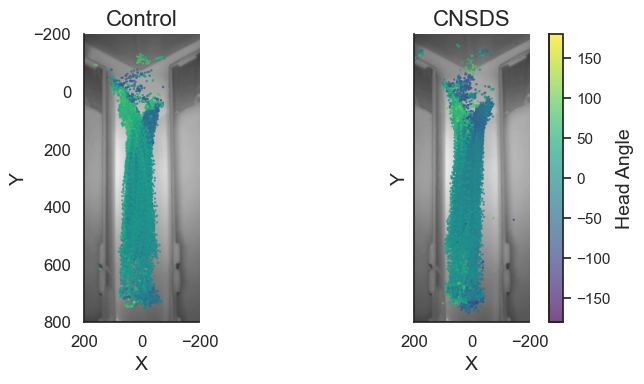

In [3393]:
# Define the conditions
conditions = ['Control', 'CNSDS']

# Create a figure with 2 subplots (one for each condition)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Iterate over the conditions and plot on respective subplots
for i, condition in enumerate(conditions):
    ax = axes[i]
    
    # Filter the data based on the condition
    condition_data = pts[pts['condition'] == condition]

    height, width, chan = frame.shape
    extent = [-x_pic, width - x_pic, height - y_pic, -y_pic]
    # Rotation angle in degrees
    angle = 2  # counter-clockwise
    # Create transform
    transform = Affine2D().rotate_deg_around(0, 0, angle) + ax.transData
    ax.imshow(frame, extent=extent, origin='upper', transform=transform)
    
    # Plot the scatter plot for the head angles with a red color scale
    scatter = ax.scatter(condition_data['normalized_x'], condition_data['normalized_y'], 
                              c=condition_data['normalized_head_angle'], 
                              cmap='viridis', s=0.5, alpha=0.7, vmin=-180, vmax=180)
    
    # Set the titles for each subplot
    ax.set_title(f'{condition}', fontsize=16)
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)

    # Set axis limits
    ax.set_xlim(200, -200)  # Set x-axis range from -200 to 200
    ax.set_ylim(800, -200)  # Set y-axis range from -200 to 800

    ax.tick_params(axis='both', labelsize=12)

# Adjust layout to avoid overlapping with the colorbar
plt.tight_layout()

# Add the colorbar with the desired location (to the side of the graph)
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', pad=0.02)
cbar.set_label('Head Angle', fontsize=14)

# Show the plot
sns.despine(top=True, right=True)
# plt.tight_layout()
plt.savefig("headangle_locations.pdf", format="pdf")
plt.show()


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_21872\4153464408.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trial_histograms = pts.groupby(['subject', 'experiment', 'condition']).apply(compute_normalized_histogram).reset_index()


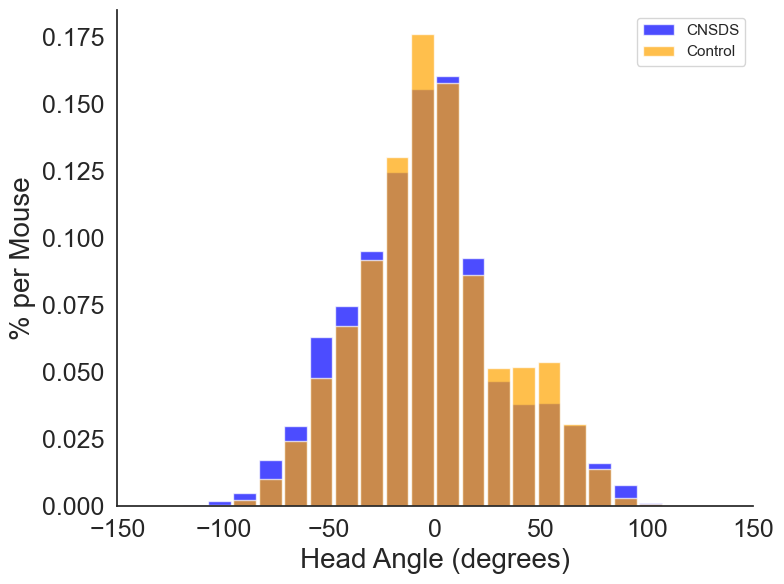

In [3395]:
# Set number of bins
bins = 30

# Define shared bin edges
angle_min = pts['normalized_head_angle'].min()
angle_max = pts['normalized_head_angle'].max()
x_bins = np.linspace(angle_min, angle_max, bins + 1)
bin_centers = 0.5 * (x_bins[:-1] + x_bins[1:])

# Function to compute normalized histogram for each trial
def compute_normalized_histogram(group):
    counts, _ = np.histogram(group['normalized_head_angle'], bins=x_bins)
    norm = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts)
    return pd.Series(norm, index=range(bins))

# Compute normalized histogram for each trial
trial_histograms = pts.groupby(['subject', 'experiment', 'condition']).apply(compute_normalized_histogram).reset_index()
trial_histograms = trial_histograms.rename(columns={i: f'bin_{i}' for i in range(bins)})

# Melt to long format
long_df = trial_histograms.melt(id_vars=['subject', 'experiment', 'condition'],
                                var_name='bin', value_name='proportion')
long_df['bin'] = long_df['bin'].str.extract(r'bin_(\d+)').astype(int)
long_df['bin_center'] = bin_centers[long_df['bin']]

# Average per group
mean_df = long_df.groupby(['condition', 'bin_center'])['proportion'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))

# Bar width
bar_width = (x_bins[1] - x_bins[0]) * 0.9

# Plot CNSDS
cnsds_data = mean_df[mean_df['condition'] == 'CNSDS']
plt.bar(cnsds_data['bin_center'], cnsds_data['proportion'],
        width=bar_width, color='blue', alpha=0.7, label='CNSDS')

# Plot Control
control_data = mean_df[mean_df['condition'] == 'Control']
plt.bar(control_data['bin_center'], control_data['proportion'],
        width=bar_width, color='orange', alpha=0.7, label='Control')

# Formatting
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Head Angle (degrees)', fontsize=20)
plt.ylabel('% per Mouse', fontsize=20)
plt.xlim(-150,150)
plt.legend()
#plt.legend(fontsize=13)
plt.tight_layout()
sns.despine(top=True, right=True)
plt.savefig("D:/Figures/_norm_headangle_distribution.pdf", format="pdf")
plt.show()


Bin	P-value		Corrected	Significant
0	6.0547e-01	1.0000e+00	False
1	3.2266e-01	1.0000e+00	False
2	3.2266e-01	1.0000e+00	False
3	5.7692e-01	1.0000e+00	False
4	1.6567e-01	1.0000e+00	False
5	1.9846e-01	1.0000e+00	False
6	2.0646e-01	1.0000e+00	False
7	1.3843e-01	1.0000e+00	False
8	1.1205e-01	1.0000e+00	False
9	3.0202e-01	1.0000e+00	False
10	1.2791e-01	1.0000e+00	False
11	5.1107e-01	1.0000e+00	False
12	8.5871e-01	1.0000e+00	False
13	8.0727e-01	1.0000e+00	False
14	3.1247e-01	1.0000e+00	False
15	9.1314e-01	1.0000e+00	False
16	7.2573e-01	1.0000e+00	False
17	6.5994e-01	1.0000e+00	False
18	1.4760e-01	1.0000e+00	False
19	1.2783e-01	1.0000e+00	False
20	9.3557e-01	1.0000e+00	False
21	5.3200e-01	1.0000e+00	False
22	4.2846e-02	1.0000e+00	False
23	3.8224e-01	1.0000e+00	False
24	5.4540e-01	1.0000e+00	False
25	6.3000e-01	1.0000e+00	False
26	1.7581e-01	1.0000e+00	False
27	3.2266e-01	1.0000e+00	False
28	3.2266e-01	1.0000e+00	False
29	3.3470e-01	1.0000e+00	False


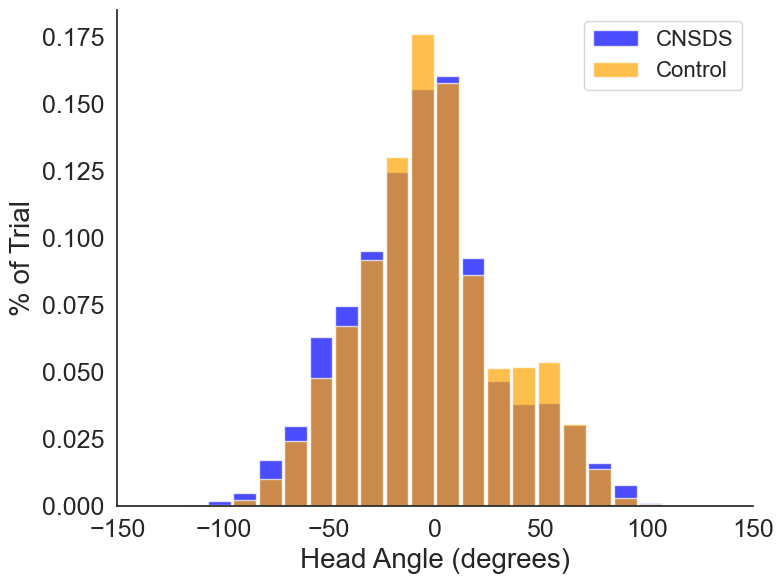

In [3396]:
# Number of bins
num_bins = bins

# Store p-values
p_values = []

# Perform t-tests for each bin
for b in range(num_bins):
    bin_data = long_df[long_df['bin'] == b]
    cnsds_vals = bin_data[bin_data['condition'] == 'CNSDS']['proportion']
    control_vals = bin_data[bin_data['condition'] == 'Control']['proportion']

    # T-test
    t_stat, p = ttest_ind(cnsds_vals, control_vals, equal_var=False, nan_policy='omit')
    p_values.append(p)

# Apply Bonferroni correction
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print p-values
print("Bin\tP-value\t\tCorrected\tSignificant")
for i, (p, p_corr, sig) in enumerate(zip(p_values, pvals_corrected, rejected)):
    print(f"{i}\t{p:.4e}\t{p_corr:.4e}\t{sig}")

# Plot with significance asterisks
plt.figure(figsize=(8, 6))

# Bar width
bar_width = (x_bins[1] - x_bins[0]) * 0.9

# Plot CNSDS
cnsds_data = mean_df[mean_df['condition'] == 'CNSDS']
plt.bar(cnsds_data['bin_center'], cnsds_data['proportion'],
        width=bar_width, color='blue', alpha=0.7, label='CNSDS')

# Plot Control
control_data = mean_df[mean_df['condition'] == 'Control']
plt.bar(control_data['bin_center'], control_data['proportion'],
        width=bar_width, color='orange', alpha=0.7, label='Control')

# Add asterisks for significant bins
for i, sig in enumerate(rejected):
    if sig:
        x = bin_centers[i]
        y = max(cnsds_data[cnsds_data['bin_center'] == x]['proportion'].values[0],
                control_data[control_data['bin_center'] == x]['proportion'].values[0])
        plt.text(x, y + 0.01, '*', ha='center', va='bottom', color='black', fontsize=16)

# Formatting
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Head Angle (degrees)', fontsize=20)
plt.ylabel('% of Trial', fontsize=20)
plt.xlim(-150, 150)
plt.legend(fontsize=16)
plt.tight_layout()
sns.despine(top=True, right=True)

# Save and show
plt.savefig("D:/Figures/_norm_headangle_distribution_with_stats.pdf", format="pdf")
plt.show()


## TRY TO FLIP THESE BASED ON WHICH SIDE IS HR (YOU'LL HAVE TO USE SIMILAR CODE YOU USED FOR PLOTTING THE X/Y POSITIONS)

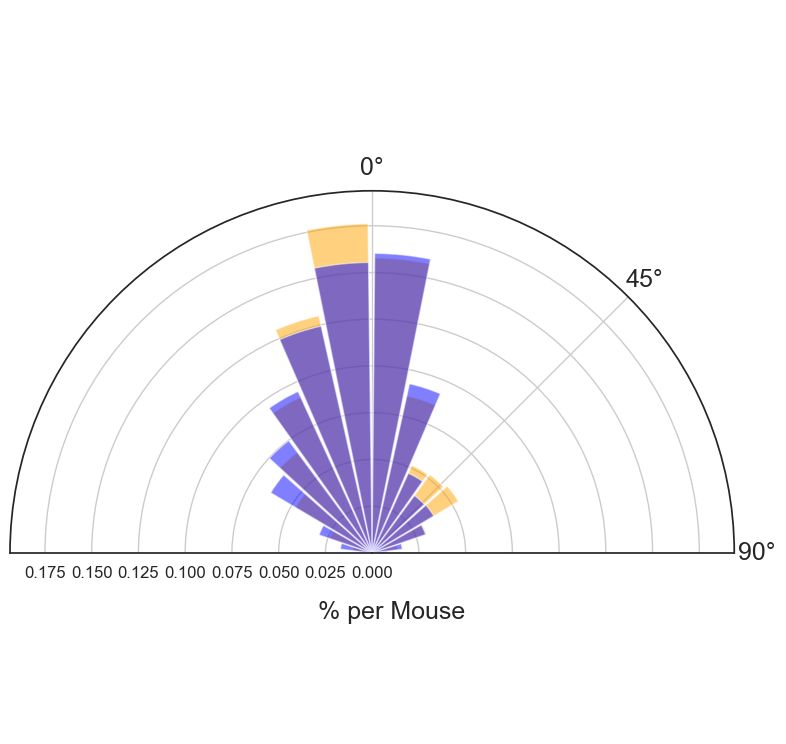

In [3440]:
### TRY TO FLIP THESE BASED ON WHICH SIDE IS HR (YOU'LL HAVE TO USE SIMILAR CODE YOU USED FOR PLOTTING THE X/Y POSITIONS)

# Convert degrees to radians — retain negative values!
mean_df['theta'] = np.deg2rad(mean_df['bin_center'])

# Polar bar width in radians
bar_width_rad = np.deg2rad((x_bins[1] - x_bins[0]) * 0.9)

# Set up polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Plot Control
control_data = mean_df[mean_df['condition'] == 'Control']
ax.bar(control_data['theta'], control_data['proportion'],
       width=bar_width_rad, color='orange', alpha=0.5, label='Control')

# Plot CNSDS
cnsds_data = mean_df[mean_df['condition'] == 'CNSDS']
ax.bar(cnsds_data['theta'], cnsds_data['proportion'],
       width=bar_width_rad, color='blue', alpha=0.5, label='CNSDS')

# Fix angle mapping and axis
ax.set_theta_zero_location('N')  # 0° at top
ax.set_theta_direction(-1)       # Clockwise
ax.set_rlabel_position(270)
ax.set_ylim(0, mean_df['proportion'].max() * 1.1)

# Custom angle labels for true -180° to 180° display
tick_locs = np.deg2rad([0, 315, 270, 90, 45])
tick_labels = ['0°', '-45°', '-90°', '90°', '45°']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels, fontsize = 18)
#ax.set_xlabel("% per Mouse")
fig.text(0.5, 0.2, '% per Mouse', ha='center', va='center', fontsize=18)

ax.set_thetamin(-90)
ax.set_thetamax(90)

ax.tick_params(axis='y', labelsize=12)

# Labels and legend
#ax.legend(loc='upper right', fontsize=13)
#plt.title("% per Mouse", fontsize=16)
plt.tight_layout()
plt.savefig("D:/Figures/headangle_polar_distribution", format="pdf")
plt.show()

# Correlations

Experiment: 10cm | Condition: Control | Variable: Trial Duration (s) | r = -0.236, p = 0.4174
Experiment: 10cm | Condition: CNSDS | Variable: Trial Duration (s) | r = 0.222, p = 0.4091
Experiment: 10cm | Condition: Control | Variable: Velocity (cm) | r = 0.549, p = 0.0420
Experiment: 10cm | Condition: CNSDS | Variable: Velocity (cm) | r = 0.282, p = 0.2904
Experiment: 10cm | Condition: Control | Variable: Start Box Time (s) | r = 0.506, p = 0.0647
Experiment: 10cm | Condition: CNSDS | Variable: Start Box Time (s) | r = 0.006, p = 0.9813
Experiment: 10cm | Condition: Control | Variable: Distance (cm) | r = 0.190, p = 0.5150
Experiment: 10cm | Condition: CNSDS | Variable: Distance (cm) | r = 0.381, p = 0.1459
Experiment: 10cm | Condition: Control | Variable: Decision Fork Time (s) | r = 0.159, p = 0.5882
Experiment: 10cm | Condition: CNSDS | Variable: Decision Fork Time (s) | r = 0.471, p = 0.0655
Experiment: 15cm | Condition: Control | Variable: Trial Duration (s) | r = -0.116, p = 0.69

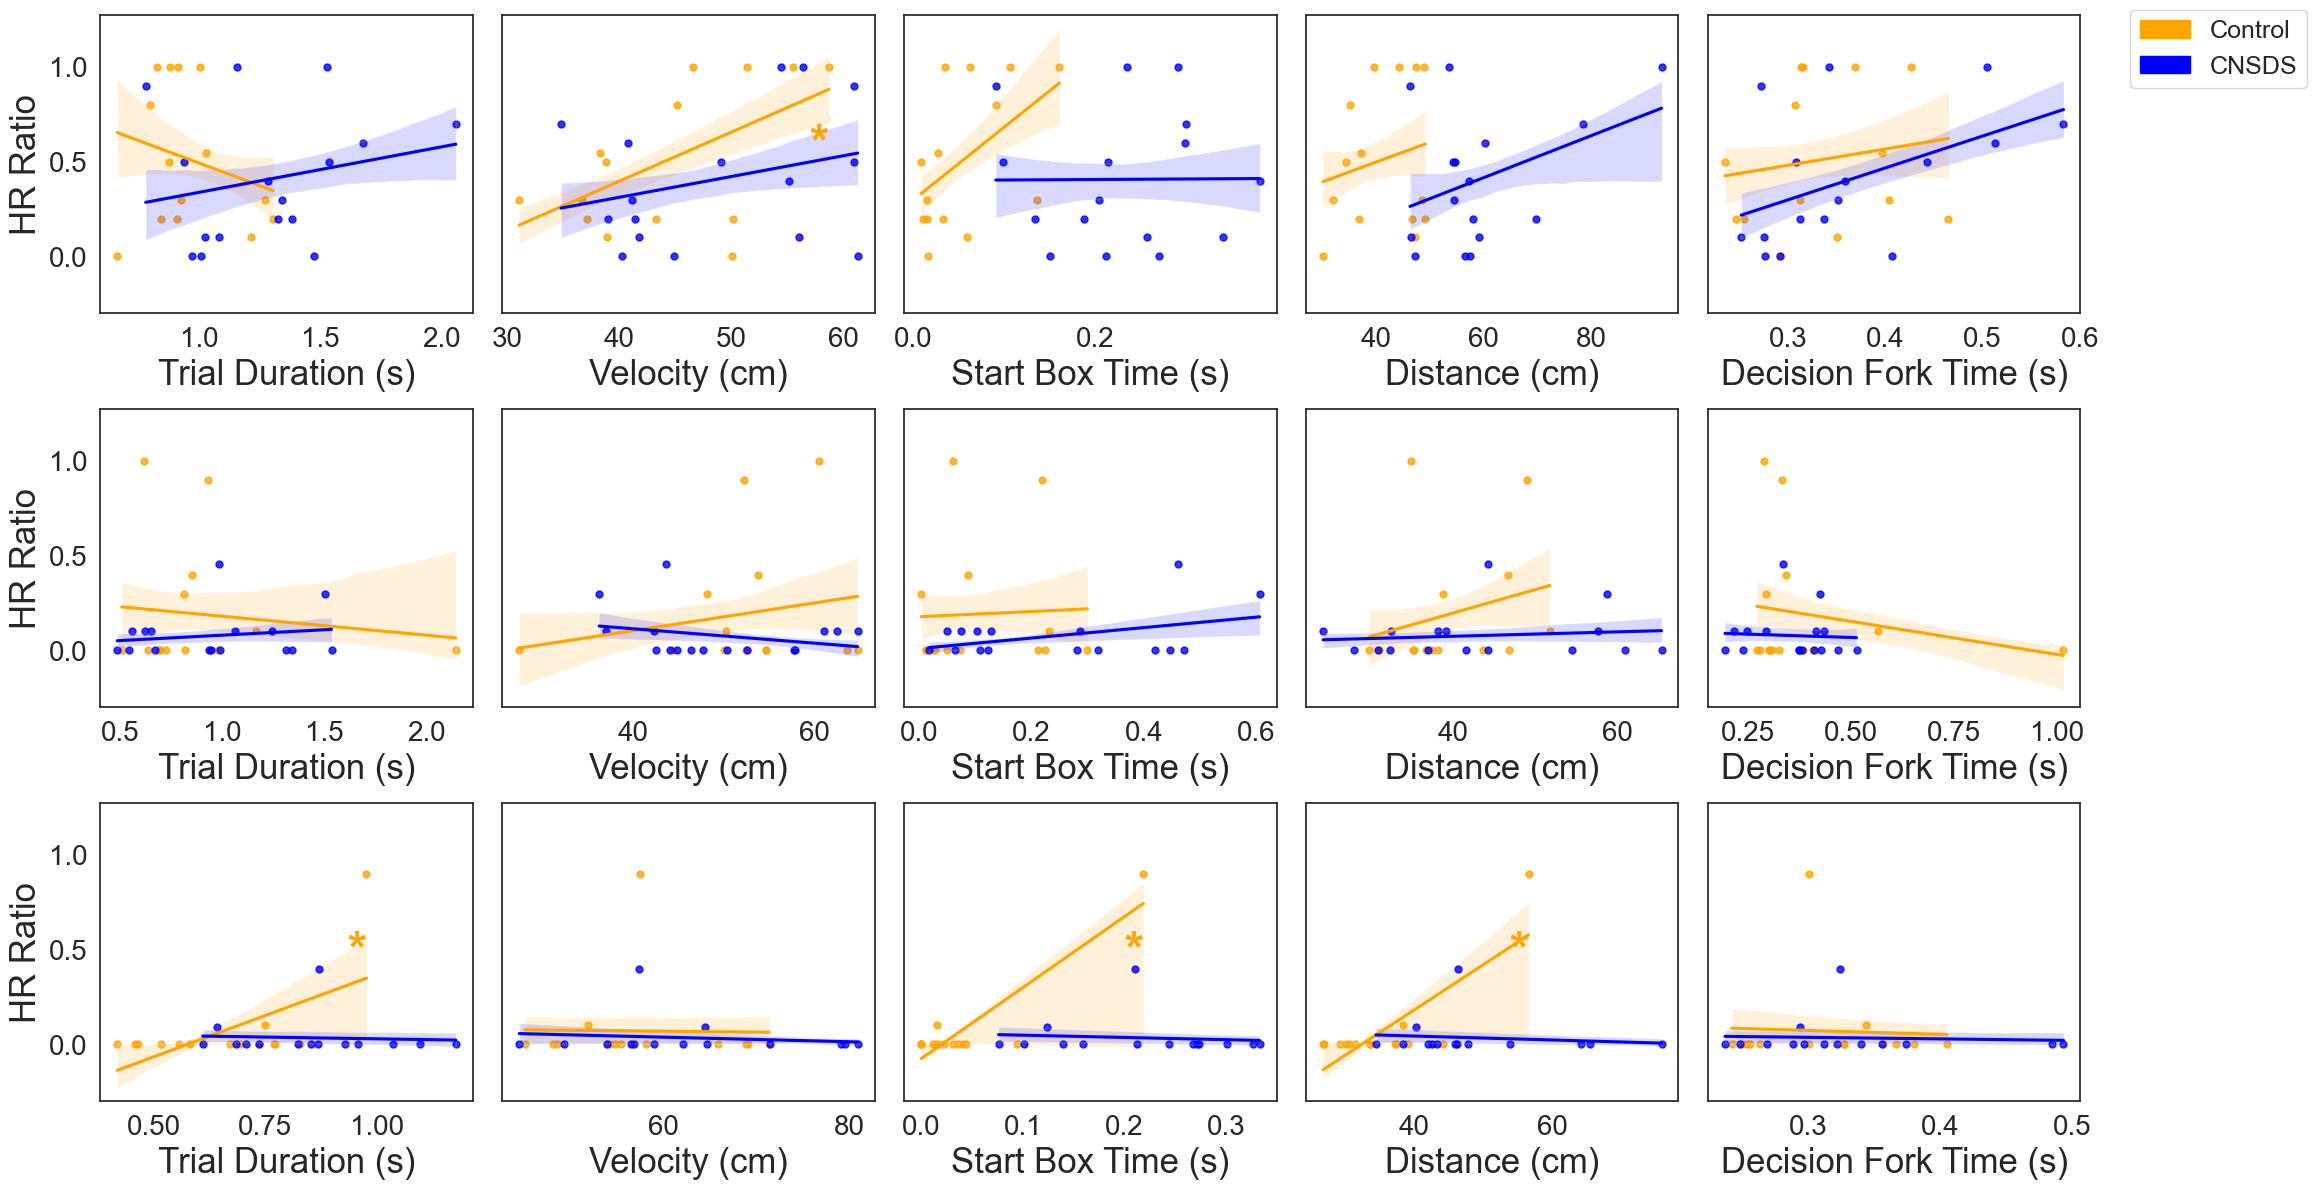

In [3412]:
import matplotlib.patches as mpatches

# Variables and custom labels
variables = {
    'avg_trial_duration': 'Trial Duration (s)',
    'avg_velocity_across_trials': 'Velocity (cm)',
    'avg_start_box_time_secs': 'Start Box Time (s)',
    'total_distance_cm': 'Distance (cm)',
    'avg_decision_time_secs': 'Decision Fork Time (s)'
}

# Drop rows with missing data
clean_df = analysis_df.dropna(subset=list(variables.keys()) + ['HR_ratio', 'condition', 'experiment'])

# Get list of unique experiments
experiments = clean_df['experiment'].unique()
n_experiments = len(experiments)
n_vars = len(variables)

# Create subplots: one row per experiment, one column per variable
fig, axes = plt.subplots(nrows=n_experiments, ncols=n_vars, figsize=(5 * n_vars, 4 * n_experiments), sharey=True)

# Handle single-row case (flatten if necessary)
if n_experiments == 1:
    axes = [axes]

for i, experiment in enumerate(experiments):
    exp_df = clean_df[clean_df['experiment'] == experiment]
    for j, (var, label) in enumerate(variables.items()):
        ax = axes[i][j] if n_experiments > 1 else axes[0][j]

        # Plot Control group (no label here)
        sns.regplot(
            data=exp_df[exp_df['condition'] == 'Control'],
            x=var, y='HR_ratio',
            color='orange', ax=ax,
            scatter_kws={'s': 25},
            ci=68  # ±1 standard error band
        )

        # Plot CNSDS group (no label here)
        sns.regplot(
            data=exp_df[exp_df['condition'] == 'CNSDS'],
            x=var, y='HR_ratio',
            color='blue', ax=ax,
            scatter_kws={'s': 25},
            ci=68  # ±1 standard error band
        )

        # Annotate significant correlations with asterisk
        for cond, color in [('Control', 'orange'), ('CNSDS', 'blue')]:
            subset = exp_df[exp_df['condition'] == cond]
            if len(subset) > 2:
                r, p = pearsonr(subset[var], subset['HR_ratio'])
                if p < 0.05:
                    x_pos = subset[var].max()
                    y_pos = subset['HR_ratio'].max() - 0.3
                    ax.text(x_pos, y_pos, '*', color=color, fontsize=35,
                            ha='right', va='top', fontweight='bold')

                # Print correlation results
                print(f"Experiment: {experiment} | Condition: {cond} | Variable: {label} | r = {r:.3f}, p = {p:.4f}")

        # Title and axis labels
        #ax.set_title(f"{experiment} | {label}", fontsize=25)
        ax.set_xlabel(label, fontsize=25)
        if j == 0:
            ax.set_ylabel("HR Ratio", fontsize=25)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='both', which='major', labelsize=20)

# Create custom legend handles
control_patch = mpatches.Patch(color='orange', label='Control')
cnsds_patch = mpatches.Patch(color='blue', label='CNSDS')

# Place legend outside to the right, adjust bbox_to_anchor to move closer/farther
fig.legend(handles=[control_patch, cnsds_patch],
           loc='upper left',
           bbox_to_anchor=(.85, 1),
           fontsize=18,
           title_fontsize=20)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on right for legend

plt.savefig("correlations_by_experiment.pdf", format="pdf")
plt.show()



In [3413]:
# subject-to-values mapping (replace number values)
attacks_values = {'WT022': 81, 'WT023': 83, 'WT025': 86, 'WT030': 15, 'WT031': 11, 'WT033': 12, 'WT038': 73, 'WT039': 68, 'WT040': 83, 'WT044': 14, 'WT045': 1, 'WT046': 6, 'WT050': 71, 'WT051': 53, 'WT052': 50, 'WT056': 9, 'WT057': 3, 'WT058': 6}
submissions_values = {'WT022': 92, 'WT023': 71, 'WT025': 63, 'WT030': 50, 'WT031': 41, 'WT033': 41, 'WT038': 128, 'WT039': 109, 'WT040': 105, 'WT044': 49, 'WT045': 42, 'WT061': 10, 'WT050': 62, 'WT051': 99, 'WT052': 46, 'WT056': 36, 'WT057': 18, 'WT058': 20}

# Convert each dictionary to a DataFrame
attacks_df = pd.DataFrame(list(attacks_values.items()), columns=['subject', 'num_attacks'])
submissions_df = pd.DataFrame(list(submissions_values.items()), columns=['subject', 'num_submissions'])

# Merge the two DataFrames on the subject column
stress_df = pd.merge(attacks_df, submissions_df, on='subject')

In [ ]:
# Step 1: Aggregate avg_start_box_time per subject
avg_start_box_time_df = analysis_df.groupby('subject', as_index=False)['avg_start_box_time'].mean()

# Step 2: Merge with stress_df
merged_df = pd.merge(stress_df, avg_start_box_time_df, on='subject')

# Step 3: Run correlations
# Correlation with num_attacks
r_attacks, p_attacks = pearsonr(merged_df['num_attacks'], merged_df['avg_start_box_time'])

# Correlation with num_submissions
r_subs, p_subs = pearsonr(merged_df['num_submissions'], merged_df['avg_start_box_time'])

# Output results
print(f"Correlation between number of attacks and avg_start_box_time: r = {r_attacks:.3f}, p = {p_attacks:.4f}")
print(f"Correlation between number of submissions and avg_start_box_time: r = {r_subs:.3f}, p = {p_subs:.4f}")

Correlation between number of attacks and avg_start_box_time: r = -0.356, p = 0.1925
Correlation between number of submissions and avg_start_box_time: r = -0.317, p = 0.2489


In [3416]:
# Step 1: Define variables to average
variables_to_average = [
    'avg_trial_duration',
    'avg_velocity_across_trials',
    'avg_start_box_time_secs',
    'total_distance_cm',
    'avg_decision_time_secs'
]

# Step 2: Compute mean per subject
behavior_means = analysis_df.groupby('subject', as_index=False)[variables_to_average].mean()

# Step 3: Merge with stress_df
stress_df = pd.merge(stress_df, behavior_means, on='subject')

Variable: avg_trial_duration
  Attacks     - r: -0.085, p: 0.7623
  Submissions - r: -0.257, p: 0.3550
----------------------------------------
Variable: avg_velocity_across_trials
  Attacks     - r: 0.144, p: 0.6085
  Submissions - r: 0.306, p: 0.2668
----------------------------------------
Variable: avg_start_box_time_secs
  Attacks     - r: -0.275, p: 0.3218
  Submissions - r: -0.360, p: 0.1874
----------------------------------------
Variable: total_distance_cm
  Attacks     - r: -0.254, p: 0.3601
  Submissions - r: -0.030, p: 0.9164
----------------------------------------
Variable: avg_decision_time_secs
  Attacks     - r: 0.017, p: 0.9533
  Submissions - r: -0.198, p: 0.4794
----------------------------------------


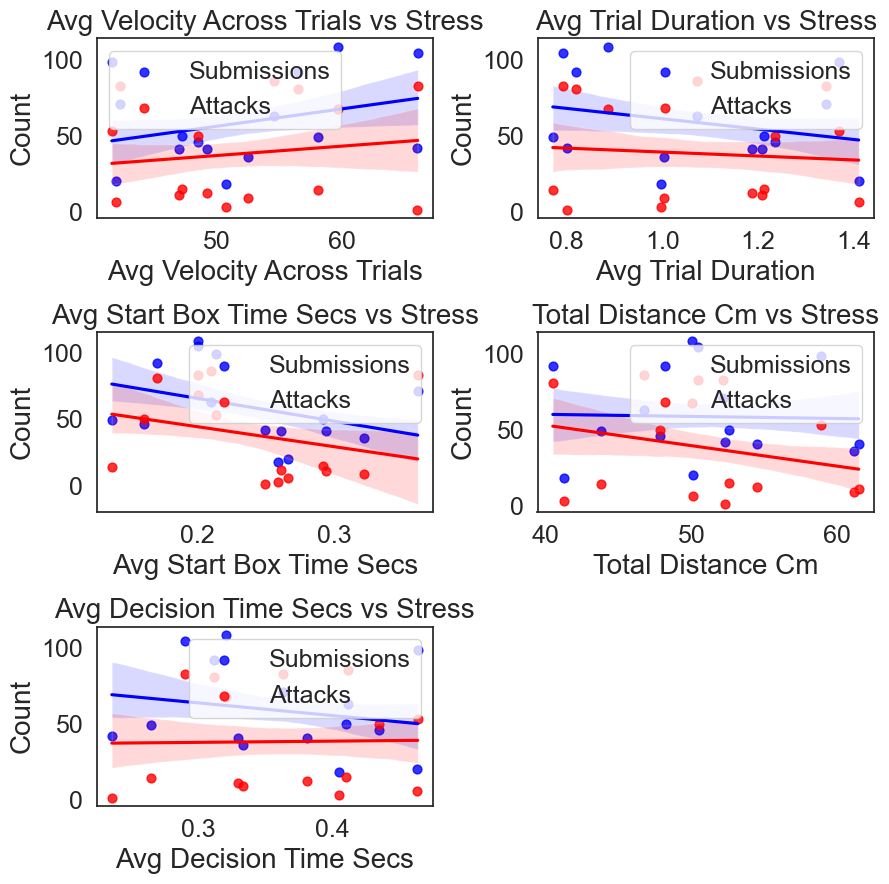

In [3418]:
# Variables to correlate
vars_to_test = [
    'avg_trial_duration',
    'avg_velocity_across_trials',
    'avg_start_box_time_secs',
    'total_distance_cm',
    'avg_decision_time_secs'
]

# Create subplots: 3 rows, 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))

# Turn all axes off initially (hide unused)
for ax in axes.flatten():
    ax.set_visible(False)

# Plot order (row, col) - first plot top-right, others follow
plot_positions = [
    (0, 1),  # First plot (index 0) top-right
    (0, 0),  # Second plot (index 1) top-left
    (1, 0),  # Third plot (index 2)
    (1, 1),  # Fourth plot (index 3)
    (2, 0),  # Fifth plot (index 4)
]

for i, var in enumerate(vars_to_test):
    row, col = plot_positions[i]
    ax = axes[row, col]
    ax.set_visible(True)

    sns.regplot(
        data=stress_df,
        x=var, y='num_submissions',
        color='blue',
        label='Submissions',
        ax=ax,
        scatter_kws={'s': 40},
        ci=68
    )


    # Plot submissions
    sns.regplot(
        data=stress_df,
        x=var, y='num_attacks',
        color='red',
        label='Attacks',
        ax=ax,
        scatter_kws={'s': 40},
        ci=68  # ~1 SE band
    )

    # Compute correlations
    r_attack, p_attack = pearsonr(stress_df[var], stress_df['num_attacks'])
    r_sub, p_sub = pearsonr(stress_df[var], stress_df['num_submissions'])


    # Print correlation results
    print(f"Variable: {var}")
    print(f"  Attacks     - r: {r_attack:.3f}, p: {p_attack:.4f}")
    print(f"  Submissions - r: {r_sub:.3f}, p: {p_sub:.4f}")
    print("-" * 40)


    # Position for asterisks - lower than before
    y_max = max(stress_df['num_attacks'].max(), stress_df['num_submissions'].max())
    x_center = stress_df[var].mean()
    offset = y_max - 0.5  # lowered from 0.3 to 0.1

    if p_attack < 0.05:
        ax.text(x_center, y_max - offset, '*', ha='center', va='bottom', color='red', fontsize=22)

    if p_sub < 0.05:
        ax.text(x_center, y_max - offset * 2, '*', ha='center', va='bottom', color='blue', fontsize=22)

    # Formatting
    ax.set_xlabel(var.replace('_', ' ').title(), fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.set_title(f'{var.replace("_", " ").title()} vs Stress', fontsize=20)
    ax.tick_params(axis='both', labelsize=18)

    # Show legend only once per axis
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=18)

# Hide the last unused subplot (bottom-right)
#fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.savefig("correlation_stress.pdf", format="pdf")
plt.show()


## Syllables correlations

In [3419]:
# Load the exported DataFrame
new_analysis_df = pd.read_csv("new_analysis_df.csv")

In [3420]:
# Step 1: Group by syllable, subject, and experiment, then average the ratio
avg_ratios = (
    new_analysis_df
    .groupby(['syllable', 'subject', 'experiment'])['ratio']
    .mean()
    .reset_index()
)

condition_info = new_analysis_df[['subject', 'experiment', 'condition']].drop_duplicates()

syllable_ratio_df = pd.merge(avg_ratios, condition_info, on=['subject', 'experiment'], how='left')

syllable_ratio_df = pd.merge(
    analysis_df,
    syllable_ratio_df[['syllable', 'subject', 'experiment', 'ratio']], 
    on=['subject', 'experiment'],
    how='left'
)


Pearson correlation results:

Syllable: 0, Condition: Control, r = 0.327, p = 0.0347
Syllable: 0, Condition: CNSDS, r = -0.029, p = 0.8501
Syllable: 1, Condition: Control, r = -0.372, p = 0.0154
Syllable: 1, Condition: CNSDS, r = -0.203, p = 0.1764
Syllable: 2, Condition: Control, r = 0.289, p = 0.0672
Syllable: 2, Condition: CNSDS, r = 0.098, p = 0.5178
Syllable: 3, Condition: Control, r = 0.143, p = 0.3661
Syllable: 3, Condition: CNSDS, r = -0.258, p = 0.0834
Syllable: 4, Condition: Control, r = 0.059, p = 0.7101
Syllable: 4, Condition: CNSDS, r = 0.261, p = 0.0792
Syllable: 5, Condition: Control, r = -0.016, p = 0.9200
Syllable: 5, Condition: CNSDS, r = -0.263, p = 0.0779
Syllable: 6, Condition: Control, r = -0.123, p = 0.4571
Syllable: 6, Condition: CNSDS, r = -0.224, p = 0.1353
Syllable: 7, Condition: Control, r = 0.145, p = 0.3996
Syllable: 7, Condition: CNSDS, r = -0.089, p = 0.5575


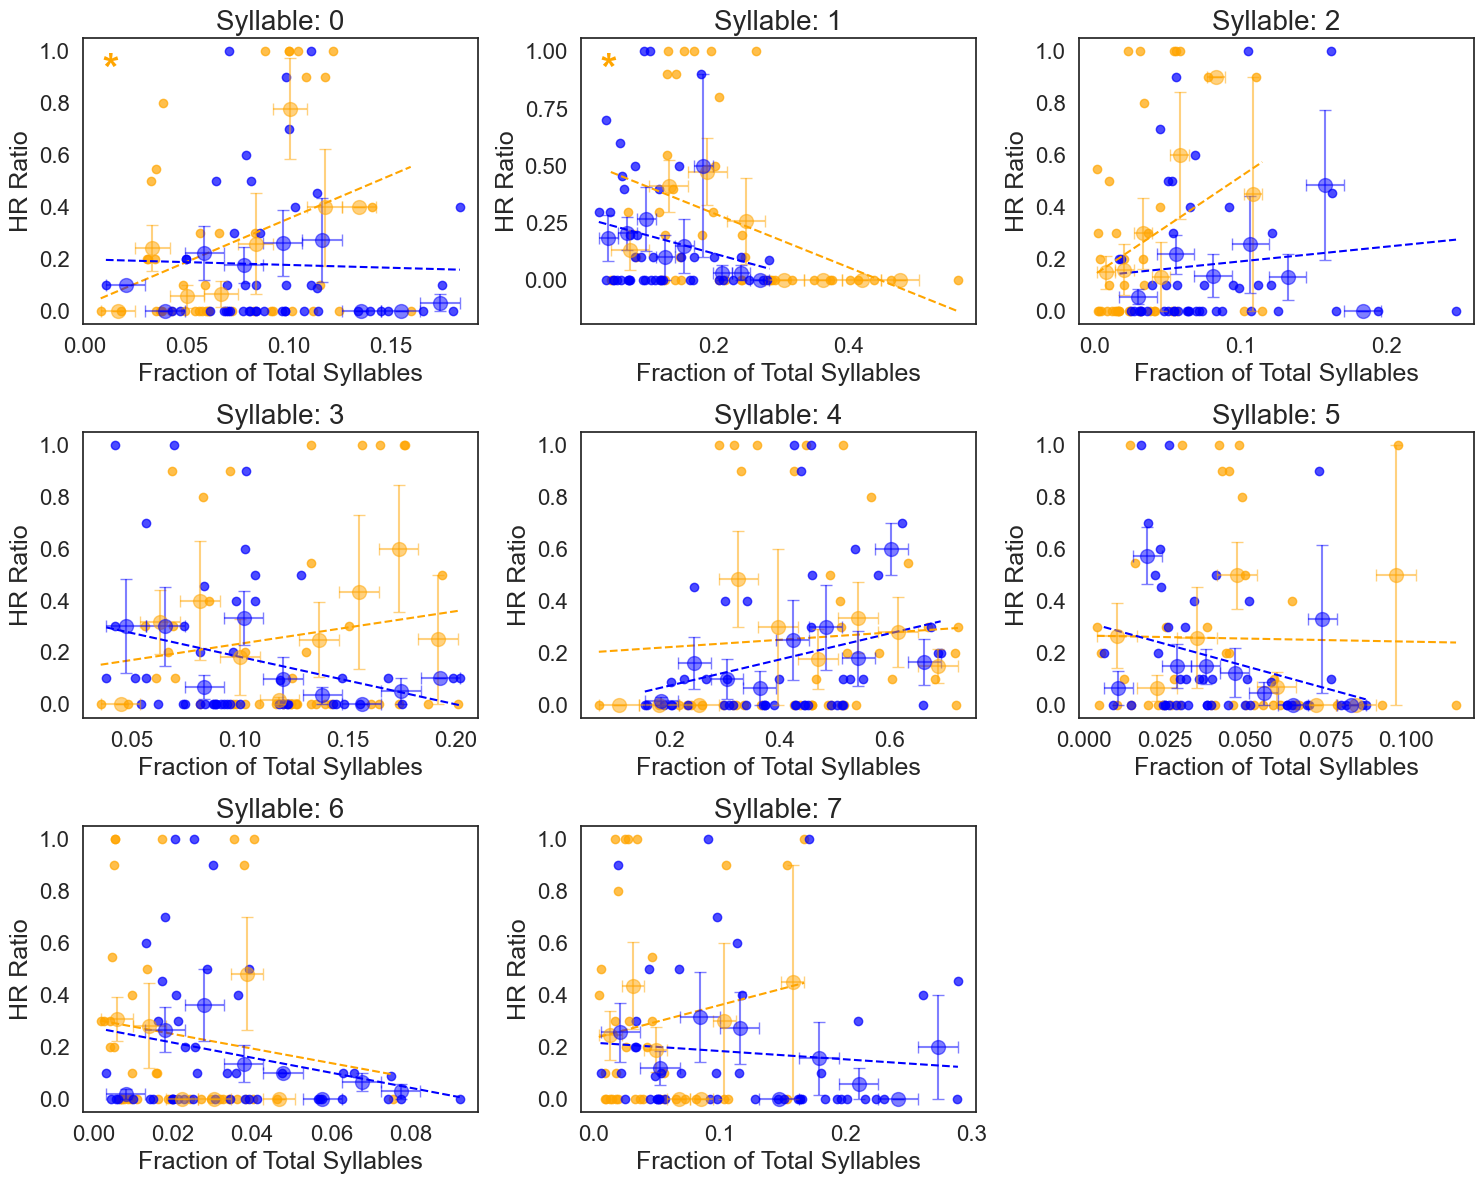

In [ ]:
from scipy.stats import linregress, pearsonr
import numpy as np
import matplotlib.pyplot as plt

colors = {'Control': 'orange', 'CNSDS': 'blue'}

syllables = syllable_ratio_df['syllable'].unique()
n_cols = 3
n_rows = (len(syllables) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

print("Pearson correlation results:\n")

for idx, syll in enumerate(syllables):
    ax = axes[idx // n_cols, idx % n_cols]
    data = syllable_ratio_df[syllable_ratio_df['syllable'] == syll]
    
    title = f"Syllable: {syll}"
    
    sig_p = {}
    
    for condition, color in colors.items():
        subset = data[data['condition'] == condition]
        x = subset['ratio']
        y = subset['HR_ratio']

        if len(x) > 1 and len(y) > 1:
            r, p = pearsonr(x, y)
            sig_p[condition] = p  # Track p-value
            print(f"Syllable: {syll}, Condition: {condition}, r = {r:.3f}, p = {p:.4f}")

            ax.scatter(x, y, color=color, alpha=0.7, label=f"{condition} (r={r:.2f})")

            # Bin for SEM error bars
            bins = np.linspace(x.min(), x.max(), 10)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            means = []
            sems = []
            
            for start, end in zip(bins[:-1], bins[1:]):
                bin_vals = y[(x >= start) & (x < end)]
                means.append(bin_vals.mean() if len(bin_vals) > 0 else np.nan)
                sems.append(bin_vals.sem() if len(bin_vals) > 1 else 0)

            means = np.array(means)
            sems = np.array(sems)
            valid = ~np.isnan(means)

            # Horizontal error bars: half bin width
            x_err = (bins[1] - bins[0]) / 2
            xerrs = np.full_like(means[valid], x_err)

            # Plot with larger points and both error bars
            ax.errorbar(
                bin_centers[valid],
                means[valid],
                xerr=xerrs,
                yerr=sems[valid],
                fmt='o',
                color=color,
                alpha=0.5,
                markersize=10,
                capsize=4
            )
            # Regression line
            slope, intercept, _, _, _ = linregress(x, y)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = intercept + slope * x_fit
            ax.plot(x_fit, y_fit, color=color, linestyle='--')

        else:
            print(f"Syllable: {syll}, Condition: {condition} — Not enough data for correlation")
            ax.scatter(x, y, color=color, alpha=0.7, label=condition)

    # Show asterisks for each condition that is significant
    y_pos = 0.95  # Start near the top of the plot
    for condition, p_val in sig_p.items():
        if p_val < 0.001:
            sig_label = '***'
        elif p_val < 0.01:
            sig_label = '**'
        elif p_val < 0.05:
            sig_label = '*'
        else:
            continue  # Skip if not significant

        ax.text(
            0.05, y_pos, sig_label,
            transform=ax.transAxes,
            fontsize=30,
            verticalalignment='top',
            horizontalalignment='left',
            color=colors[condition],
            weight='bold'
        )
        y_pos -= 0.08  # Move down for next asterisk if needed


    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Fraction of Total Syllables', fontsize=18)
    ax.tick_params(axis='both', labelsize= 16)
    ax.set_ylabel('HR Ratio', fontsize=18)
    ax.grid(False)
    # ax.legend(fontsize=8)

# Turn off unused axes
for empty_ax in axes.flatten()[len(syllables):]:
    empty_ax.axis('off')

plt.tight_layout()
plt.savefig("D:/Figures/correlation_syllables.pdf", format="pdf")
plt.show()
